In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt

Package not installed


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "LiH_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
#num_tapered = molecule['num_tapered']

LiH_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


/usr/local/lib64/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


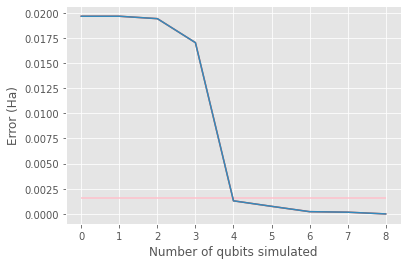

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

Exact ground state energy:  -7.882762230972003
[(1.0, '11111110'), (0.0, '00000000'), (0.0, '00000001'), (0.0, '00000010'), (0.0, '00000011')]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


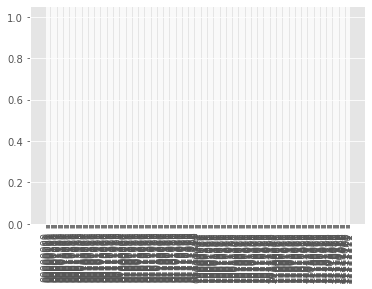

In [5]:
import numpy as np
from qat.dqs.hamiltonians import SpinHamiltonian

ham_rot = cs_tools.rotate_operator(mol_circ.ham_rotations, ham)
full_terms = [Term(coeff, op, list(range(num_qubits))) for op, coeff in ham.items()]
ham_spin = SpinHamiltonian(nqbits=num_qubits, pauli_terms=full_terms)
ham_matrix = ham_spin.get_matrix()
eigvals, eigvecs = np.linalg.eigh(ham_matrix)
gs = sorted(list(zip(eigvals, eigvecs)), key=lambda x:x[0])[0]

print("Exact ground state energy: ", gs[0])
basis_states = [bit.int_to_bin(i, num_qubits) for i in range(2**num_qubits)]
sig_states = sorted(list(zip(abs(gs[1])**2, basis_states)), key=lambda x:-x[0])
print(sig_states[:5])

fig, ax = plt.subplots()
l1=ax.bar(basis_states, [abs(a)**2 for a in gs[1]])
l2=ax.set_xticklabels(basis_states, rotation=90)

In [6]:
nonconstate = mol_circ.reference_state()
reverse_rot = []
for angle, rot in mol_circ.ham_rotations[::-1]:
    if angle == 'pi/2':
        reverse_rot.append([-np.pi/2, rot])
    else:
        reverse_rot.append([-angle, rot])

anz={}
for amp, state in sig_states[:2]:
    differs=[index for index, b in enumerate(state) if nonconstate[index]!=b]
    #pot_ops=[]
    #for op in uccsd.keys():
    #    diff_bits = {op[i] for i in differs}
    #    same_bits = {op[i] for i in range(num_qubits) if i not in differs}
    #    if diff_bits in [{'X'}, {'Y'}, {'X', 'Y'}] and same_bits in [{'I'},{'Z'},{'I', 'Z'}]:
    #        pot_ops.append(op)
    blank_op = ['I' for i in range(num_qubits)]
    for i in differs:
        blank_op[i] = 'X'
    op = ''.join(blank_op)
    if set(op)!={'I'}:
        anz[op] = amp

out_anz = cs_tools.rotate_operator(reverse_rot, anz)
out_anz

{'XXXXIXIX': -7.921811650862258e-50,
 'XXYXZXIX': 2.1548441626151528e-49,
 'XZXXIXIX': 4.507485188699485e-40,
 'XZYXZXIX': -1.2260993539130828e-39,
 'XIXYXXZX': 3.749399456654416e-33,
 'XZYYIYIY': 4.507485188699485e-40,
 'XZXYZYIY': 1.2260993539130828e-39,
 'XIYXXYZY': -3.749399456654416e-33,
 'XXYYIYIY': 2.112821464462044e-17,
 'XXXYZYIY': 5.747171480463665e-17,
 'XXXXIZIX': 2.112821464462044e-17,
 'XXYXZZIX': -5.747171480463665e-17,
 'XZXXIZIX': -1.2021885746794326e-07,
 'XZYXZZIX': 3.2701219704316463e-07,
 'XIXYXZZX': -0.9999999999999393}

In [7]:
import random
#anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF
#anz_ops = ['IIYXX', 'ZYIYX', 'YZZXY', 'IYIZI', 'ZZYYY']#random.choices(list(uccsd.keys()), k=5)
#print(anz_ops)
#anz = {op:uccsd[op] for op in anz_ops}
anz=uccsd
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()

In [8]:
pauli_terms = [Term(coeff, op, list(range(num_sim_q))) for op, coeff in ham_dict.items()]
hamiltonian = Observable(num_sim_q,
               pauli_terms=pauli_terms)
print("Hamiltonian:", hamiltonian)

Hamiltonian: -6.995891461571837 * I^4 +
-0.36527194458111234 * (Z|[0]) +
-0.36527194332541135 * (Z|[1]) +
0.11384398820287055 * (ZZ|[0, 1]) +
0.2118901621639898 * (ZZ|[0, 2]) +
-0.09275797389467443 * (Z|[2]) +
-0.0604402766899614 * (ZZZ|[0, 1, 2]) +
0.11395339246515192 * (ZZ|[1, 2]) +
0.21189016307872496 * (ZZ|[1, 3]) +
-0.06044027505833438 * (ZZZ|[0, 1, 3]) +
-0.09275797114745707 * (Z|[3]) +
0.11395339246515192 * (ZZ|[0, 3]) +
0.08460154541832536 * (ZZZZ|[0, 1, 2, 3]) +
-0.05628953731783007 * (ZZZ|[1, 2, 3]) +
-0.05628953968911222 * (ZZZ|[0, 2, 3]) +
0.12274418444186225 * (ZZ|[2, 3]) +
-0.01020265262547487 * (X|[0]) +
-0.01648847140929835 * (Y|[0]) +
-0.010202648834573915 * (XZ|[0, 2]) +
-0.016488471409297753 * (YZ|[0, 2]) +
-0.006724263099089901 * (XZZ|[0, 2, 3]) +
-0.01086705602230638 * (YZZ|[0, 2, 3]) +
-0.004737006886064594 * (XZZZ|[0, 1, 2, 3]) +
-0.007655461239640158 * (YZZZ|[0, 1, 2, 3]) +
-0.005763139462662657 * (XZZ|[0, 1, 2]) +
-0.009313786480388758 * (YZZ|[0, 1, 2]) +
-0.00

In [9]:
gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
prog = Program()
qbits_reg = prog.qalloc(num_sim_q)
params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

for gate, var_num, q_pos in instructions:
    q_pos = [num_sim_q-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
    if gate == 'RZ':
        prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
    elif gate == 'CX':
        prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
    else:
        prog.apply(gate_dict[gate], qbits_reg[q_pos[0]])

qc = prog.to_circ()

In [ ]:
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman
#from qat.plugins import SPSAMinimizePlugin
#from qat.plugins import PSOMinimizePlugin
inputx=[0.4228976759111122, 1.0666307603594822, 1.5423818244762673, 0.548119327527277, 0.24802500983832768, 0.6616805057569646, 0.4919128322948912, 0.19672796552733285, 0.508455939425062, 0.12033529060194735, 0.3753895305606445, 0.8156788843460447, 1.7904377684695711, 0.08984325773976987, 0.4015563975011386, 1.6275872286354882, 1.268209179985208, 1.3450532167182174, 0.29954914172172187, 0.46690728004896204, 0.42475145892075444, 0.017768759399279944, 1.2361077094279669, 0.9503678773301122, 0.6935457219762141, -0.12348821951338716, 0.7610891889079351, 0.3581230873524468, 0.5305540123226947, 0.9231926501281018, 0.7559834004757447, 1.4809274912979211, 1.0554755920934609, 0.5917710361549097, 0.20024679867376444, 0.9646903294840646, 1.831902169519928, 0.9061429734049018, -0.008336455695854119, 0.8777694924257312, 0.4618048602417346, 1.0120996653721528, 0.411878776816588, -0.06619173554165307, -0.08805563046712504, 0.5528183559269477, 0.07408000287421336, 0.7335529190730502, 1.1853911891824949, 0.9621617754348691, 0.5331590071433953, 0.1832279428235315, 0.2993827770432154]
inputx.reverse()
theta0 = inputx#mol_circ.init_param
linalg_qpu = LinAlg(use_GPU=False)

#optimizer_pso = PSOMinimizePlugin(theta0, max_iter=50, swarm_number=10)
#optimizer_spsa = SPSAMinimizePlugin(theta0)
optimizer_scipy = ScipyMinimizePlugin(method="COBYLA",
                                      tol=1e-3,
                                      options={"maxiter": 2000})

qpu = optimizer_scipy | linalg_qpu

job = qc.to_job(job_type="OBS", observable=hamiltonian)

result = qpu.submit(job)

print("Minimum energy =", result.value)
print("Optimal angles =", result.meta_data["parameters"])

In [ ]:
nfev = len(eval(result.meta_data['optimization_trace']))
energy=eval(result.meta_data['optimization_trace'])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy[50:]], label='CS-VQE convergence', color = "black")
ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='red', label='Noncontextual ground state energy', ls='--')
#plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
ax.set_xlabel("Optimization count")
ax.set_ylabel("Logarithmic error [log(Ha)]")
ax.legend()

In [ ]:
fig.savefig('plots/'+speciesname+'_CS-VQE_test.png', dpi=300, bbox_inches='tight')

In [ ]:
data={}
for k in result.meta_data.keys():
    data[str(k)] = result.meta_data[k]
    
with open("data/QLM_circuits/"+speciesname+"_CS-VQE_test.json", "w") as outfile: 
    json.dump(data, outfile)

In [ ]:
energy1 = [-96.30917534069266, -96.30386507957516, -96.31457894382426, -96.35519559836737, -96.30406808581705, -96.3480970943841, -96.32856393677496, -96.30467931386185, -96.23272926212863, -96.33968701846499, -96.27911136424285, -96.25147944722447, -96.27421104110877, -96.30740257237542, -96.32871464521371, -96.27392599115691, -96.41249072094583, -96.30205918187744, -96.30599101060994, -96.31279843563532, -96.2633094339858, -96.36702615873389, -96.3150672880912, -96.30272301935635, -96.28155466581522, -96.3145573643412, -96.27775592506829, -96.32294694519615, -96.32493181186793, -96.31259859744807, -96.30915232436563, -96.31259933038329, -96.32052250668362, -96.31522512239705, -96.38744726151465, -96.38069877698896, -96.3750797309393, -96.3744804018869, -96.37737875429958, -96.37712607150891, -96.3840330358278, -96.38866168226141, -96.37335829957715, -96.3763671776925, -96.3777268731093, -96.38366656735447, -96.38806684828211, -96.39117493451569, -96.39501981110413, -96.39844937040905, -96.40371183326963, -96.40694265054569, -96.41188127801534, -96.41826769651854, -96.47056684974687, -96.4255408000337, -96.43198639125397, -96.43800116252773, -96.44508647260488, -96.44755440616629, -96.45211294352445, -96.46213689940372, -96.4609219065027, -96.47003746190316, -96.46628556368202, -96.4657161942571, -96.46443338403974, -96.45953993183959, -96.46006429897488, -96.46471178178126, -96.46810549193685, -96.47330441134805, -96.52106507516444, -96.48025426943227, -96.48918603708199, -96.49416093461754, -96.49730181108599, -96.50125791847884, -96.50784851894687, -96.51057424445023, -96.5181200381309, -96.51975565583085, -96.53167662288331, -96.60127266843867, -96.5397509218204, -96.54474706732368, -96.54819021218077, -96.55262321189007, -96.55689520950399, -96.56284987076039, -96.56059918816031, -96.56200682614782, -96.55958954884733, -96.56374205287378, -96.56816207494651, -96.57003077974649, -96.56917005900836, -96.57601792220929, -96.58331153255274, -96.5853812459512, -96.58992587984, -96.60494935330972, -96.67966566814584, -96.61000090110505, -96.61869907548375, -96.62675282795693, -96.63532598350979, -96.64120850035141, -96.6415797363565, -96.64325076488157, -96.64404419180458, -96.65414102228179, -96.65841504146421, -96.66161187477032, -96.66599119199353, -96.66953052148843, -96.67933516200974, -96.68475437584559, -96.76285064106692, -96.68041099392896, -96.68364425097684, -96.68821674785175, -96.69403596066869, -96.69723339872812, -96.70227612555824, -96.70715272907736, -96.71617810205373, -96.72902674457228, -96.73411426532698, -96.73878008899301, -96.74740015986896, -96.75785774721362, -96.76300834579474, -96.85099955317402, -96.76722873727402, -96.7872884466133, -96.7874423442965, -96.78666689686611, -96.78969232048718, -96.79050845511661, -96.79302879787211, -96.79430130674321, -96.8017548800846, -96.80799458966044, -96.81934406332611, -96.83109852334756, -96.82816339122127, -96.83448647277365, -96.8412879192517, -96.84790726329176, -96.85512283237328, -96.94454217622385, -96.8537739994318, -96.86527777937557, -96.880708772158, -96.88917365114429, -96.89680615970572, -96.90108433853162, -96.90952394620311, -96.9121044794294, -96.92926312791884, -96.93137641197482, -96.92661233197363, -96.93617488063632, -96.94435848008608, -96.94641023115082, -97.0365635599987, -96.95400312593179, -96.9588238911015, -96.97288354010134, -96.9638086431648, -96.96489232900085, -96.97736382144637, -96.98734287653589, -96.99954794707865, -97.00908624910754, -97.02220242740377, -97.02430353089261, -97.03168740950086, -97.03445635384207, -97.0359697988428, -97.04088843449182, -97.12420197748064, -97.05952910304102, -97.06449037649392, -97.06735033090193, -97.08624087786947, -97.09846124354257, -97.1071847389323, -97.09659569223994, -97.1008233491634, -97.10537299016181, -97.11644310652557, -97.12052071045714, -97.13008141908828, -97.22629874623539, -97.13868405194953, -97.13557911684423, -97.14869088899879, -97.15926891661996, -97.16100945953866, -97.17060423215894, -97.17826959595318, -97.18646164041107, -97.1897141479016, -97.21307863023691, -97.2014619795911, -97.21823024783126, -97.22510844917237, -97.22375872666969, -97.22813101164623, -97.30952308242017, -97.2328965932966, -97.24634625227854, -97.2507650126213, -97.2575645388116, -97.27305183102439, -97.28097992691848, -97.27983968866069, -97.28871331300915, -97.30191053271172, -97.28784474307193, -97.29409408206969, -97.29220342308564, -97.30960014527993, -97.38269702257463, -97.32113741072155, -97.3219481537197, -97.32687110951022, -97.33182302911813, -97.36721829762485, -97.35961603489291, -97.34758828499089, -97.36532280337056, -97.36288200848034, -97.37653772270549, -97.38267043454445, -97.38088769401823, -97.37435023123076, -97.39852906024547, -97.46373919132125, -97.41345053140661, -97.39016654168996, -97.40114651870677, -97.41385066310865, -97.41187514335014, -97.40217743038077, -97.4320068458474, -97.42656350908035, -97.42995919983598, -97.44366301538051, -97.42915318712174, -97.43439471046096, -97.43264007635105, -97.44965782339776, -97.43755852646649, -97.46475631575993, -97.50548851640298, -97.45710743435606, -97.43545939421375, -97.46535518192235, -97.46336168809759, -97.47132143249473, -97.48269356673461, -97.49290071272185, -97.49435242984424, -97.45592273337543, -97.48169736595705, -97.47210699064291, -97.43356453986604, -97.49168739880542, -97.46822823980206, -97.47597144999094, -97.46429935221876, -97.47786463496166, -97.49479728076192, -97.48020753816537, -97.50276429803405, -97.48927935296169, -97.43337236134968, -97.4588359542246, -97.47469567258821, -97.48528797656616, -97.47702906879769, -97.4553187761078, -97.48233705288877, -97.47296873673287, -97.51870178935222, -97.5438343004132, -97.49114790937678, -97.53376894397867, -97.51673516453188, -97.46057979281161, -97.47314161550477, -97.48348404949387, -97.53194281650717, -97.51212920023771, -97.5066428796355, -97.4583934341896, -97.48956281373394, -97.519800803435, -97.48142377867529, -97.53516531381024, -97.51495041911907, -97.5416754187232, -97.52602053898654, -97.54218481907212, -97.45486829002914, -97.50251147234883, -97.49752884533432, -97.5338308901164, -97.55056536647763, -97.5874547408929, -97.53387394884201, -97.55531129236698, -97.55430785304549, -97.49802699467149, -97.56047125179549, -97.5320874469944, -97.55958755518573, -97.53348123342194, -97.55822912010699, -97.56873445877936, -97.55638593386554, -97.53913187450365, -97.5851562612038, -97.58137788353615, -97.57987944595793, -97.59121046583932, -97.62759312649894, -97.57629156840855, -97.54590204949966, -97.59547113371632, -97.60233335227143, -97.61272278598959, -97.5897163461737, -97.59540759164943, -97.59079275290023, -97.60208877270912, -97.60417661037407, -97.59203789473031, -97.61671751900805, -97.59593453083924, -97.57565796729506, -97.62878444560756, -97.66604558171437, -97.63904367037465, -97.6376205848772, -97.65344154657556, -97.61337882381142, -97.65542438298763, -97.64583126931578, -97.61937992112722, -97.59416731233046, -97.66258118838459, -97.66895413302723, -97.72186666592891, -97.66066208494419, -97.67371376780352, -97.67644260023052, -97.68641791628949, -97.68974753660545, -97.6362315347298, -97.66594886610514, -97.68615904828523, -97.6957554517302, -97.69925562004568, -97.70387614235823, -97.6556006714542, -97.69664281958079, -97.69920790930614, -97.6539187480872, -97.71649076592796, -97.71891398229589, -97.71248457942382, -97.73021277628087, -97.76865013596527, -97.75219921051165, -97.7428792360318, -97.74831116738856, -97.72483194043804, -97.77102979320149, -97.84088952037982, -97.72750135874705, -97.7700533937096, -97.71011173066826, -97.77338760913037, -97.78708085579417, -97.7848157084876, -97.79420816099343, -97.7095194347911, -97.80505221978333, -97.76115678017524, -97.77920881106641, -97.81498887265367, -97.80828840331658, -97.79848071155152, -97.81138500466686, -97.83128483463194, -97.82477286717668, -97.84113243038473, -97.90716933105863, -97.84690482479871, -97.85129876310819, -97.84852022104866, -97.84607143618958, -97.88527710649643, -97.89149202764821, -97.79755711845984, -97.8268994544071, -97.86085788525364, -97.89108894491349, -97.89914373975458, -97.92715099947291, -98.02478981793921, -97.88898587346438, -97.86693115812326, -97.92048019831066, -97.92878164642468, -97.9334405185816, -97.92824945990536, -97.90186138492966, -97.94268810585133, -97.94400352049259, -97.90636455311484, -97.97134352869105, -97.96618420244063, -97.97610533741162, -97.93242424675142, -97.98841892551013, -98.00188968651861, -98.00874872141087, -97.98593012548551, -98.01204179428099, -98.03150435897157, -98.12324990355974, -97.99379473946436, -98.05016090078998, -98.03873398339736, -98.01671950107176, -98.04476715332972, -98.01721656171088, -98.08989701670959, -98.07282662075464, -98.02183422690189, -98.08648564102242, -98.05026278685283, -98.08292796646808, -98.10193029537707, -98.10598971544447, -98.06782055513382, -98.06719685661271, -98.13457597486125, -98.21548704872609, -98.13285240903228, -98.13388875363766, -98.14060690347425, -98.12535509597966, -98.17969062712679, -98.1778406532577, -98.17806600581753, -98.17363054771025, -98.20245471547254, -98.19640777145385, -98.16581000293482, -98.19736857619793, -98.18758041447515, -98.22549375316405, -98.30575562372923, -98.2376201146173, -98.22434595974339, -98.20903350505586, -98.17506608634514, -98.21925391821316, -98.25414533007057, -98.27528404618444, -98.24441487783601, -98.2912004656784, -98.2773330542448, -98.25136278697335, -98.24162151900893, -98.29831333496429, -98.28768471720132, -98.32198723010913, -98.38515141053085, -98.33849939410605, -98.33282214324589, -98.35043984314535, -98.3392307188383, -98.2892785164211, -98.31227045235374, -98.3222094551676, -98.37246239503398, -98.35406690357637, -98.36466868966662, -98.29680040749291, -98.35396645335712, -98.38890875945738, -98.44059319262722, -98.3918668995299, -98.34970759831276, -98.3974731251052, -98.37001678015436, -98.40030737660967, -98.40103238510855, -98.41077972538798, -98.36491762466473, -98.43142369805155, -98.40175620184712, -98.41092752699012, -98.42034507246268, -98.36497617420477, -98.4305154669774, -98.40861893334525, -98.37966480391898, -98.4427633161541, -98.44272170253016, -98.43553187606184, -98.42667385532106, -98.35489152190678, -98.39759622485062, -98.43598783938926, -98.4524203239931, -98.43139201941548, -98.44319891500659, -98.440479483086, -98.4409319551769, -98.42997958554837, -98.44040515653934, -98.43002810707947, -98.43924670401577, -98.41186826597375, -98.37426349098229, -98.43837350412566, -98.42066386261236, -98.41987450202404, -98.43776121428795, -98.42195269092034, -98.39960111741632, -98.42423948816747, -98.44752185061999, -98.42034058010175, -98.44012012966343, -98.40478179256894, -98.36120375801396, -98.44231865701883, -98.43770484357, -98.43577904039522, -98.42840991411678, -98.4155515990843, -98.43451543124566, -98.41810714713854, -98.39690436567422, -98.4442239589065, -98.41438748817446, -98.44467466301253, -98.39825243649197, -98.44672028120733, -98.40796340798569, -98.44597380618598, -98.42970385697414, -98.43695361736718, -98.43828195223537, -98.44145216853607, -98.44425786568961, -98.41848660583244, -98.44899079791485, -98.46655974122953, -98.4577754250167, -98.40893782018156, -98.45182965393897, -98.4315407331593, -98.4378894499919, -98.43302953381536, -98.39838811645804, -98.45563250374893, -98.44117122730617, -98.44071969046236, -98.42432898280728, -98.45315304221536, -98.42288833490915, -98.45269103593422, -98.42844131123954, -98.45325051534833, -98.42608588746563, -98.4533607632477, -98.46493605397355, -98.42924753031186, -98.45392332352986, -98.43830027676046, -98.44566197107466, -98.42898369425211, -98.45460019623414, -98.42537813651866, -98.45521970066973, -98.44008186571689, -98.43324749854489, -98.45423142991733, -98.46637876139103, -98.43824072168594, -98.45467321393288, -98.43162508445141, -98.45585533671544, -98.46684539722852, -98.46203899178995, -98.47301498430626, -98.47681437496773, -98.42011033413402, -98.45886386461336, -98.44167848401139, -98.46151915835453, -98.43692400090309, -98.45736183041855, -98.42011811067376, -98.45963323787821, -98.44660795296427, -98.4378891733518, -98.45812625379054, -98.46515453265464, -98.47233991565173, -98.46320630983632, -98.4371578197262, -98.46022701615092, -98.46354447119636, -98.44599532523591, -98.46673329833546, -98.44646448035536, -98.4608637250587, -98.45307960310635, -98.45752271924371, -98.46631127819255, -98.4757456384399, -98.47006573865619, -98.46793969211716, -98.46917282876724, -98.45076351887991, -98.46526775925308, -98.46971029752774, -98.47327354316954, -98.47224219030785, -98.47484446197461, -98.47568990267382, -98.47729610591145, -98.47099891419374, -98.47797163622855, -98.46987595517624, -98.47875809887955, -98.47134661382636, -98.47475418246822, -98.48088787516923, -98.47473024045858, -98.48062707820945, -98.46007141873307, -98.48400522928175, -98.48174004443148, -98.47401947123012, -98.4852499143401, -98.4833149984529, -98.45923374435934, -98.4736486775876, -98.48306116037867, -98.48468752774623, -98.46863780370285, -98.47781624997718, -98.47704841284965, -98.48062296134478, -98.47904517421365, -98.4847222127963, -98.47683278563436, -98.48553211601467, -98.47526319240869, -98.48169138860938, -98.48039813458523, -98.4909779104621, -98.48824876595586, -98.4892767816208, -98.47720519131022, -98.48945327257569, -98.48634765303117, -98.49120272137242, -98.48483175689057, -98.48931102367867, -98.49173472942543, -98.48512399422326, -98.48624406043618, -98.48919493694142, -98.48332752737149, -98.48698509429617, -98.48470461842398, -98.49687086906023, -98.49711584222369, -98.49149977472732, -98.4833590836026, -98.48235179949943, -98.4908700378801, -98.48701093410023, -98.48828387987723, -98.49554054877525, -98.49868436316763, -98.49495759715397, -98.49694284260275, -98.49259490629925, -98.48278398226013, -98.48866449979785, -98.49860467222659, -98.49989486765254, -98.49489429948794, -98.48746315263018, -98.4780724364478, -98.49289961418825, -98.48375169343028, -98.49486113049657, -98.48689396351038, -98.48639940150166, -98.48359466326409, -98.49319218263639, -98.50222836719897, -98.50083331387022, -98.49934055422318, -98.48910660164375, -98.49247779964753, -98.50059717531444, -98.49568562758472, -98.49850458357261, -98.50063534181827, -98.49043194439183, -98.49273524657427, -98.49165530041297, -98.48960486799695, -98.49158360804175, -98.49078957388181, -98.49292360088923, -98.49439369317346, -98.50014152732078, -98.4941781450772, -98.4986713284605, -98.50291479762619, -98.49423231391705, -98.48244812595628, -98.49917799104526, -98.48904348230778, -98.49867870322117, -98.49155286157405, -98.49636162322714, -98.50723947719102, -98.50784112346454, -98.50124322256201, -98.50179548735551, -98.49354876252708, -98.49951848699382, -98.49341579123227, -98.506021203631, -98.49198906251479, -98.50084647316659, -98.50333270343567, -98.49125755320249, -98.5013559547289, -98.49760736207055, -98.49814924136868, -98.50698296925553, -98.49445945892127, -98.49435065129954, -98.49847586639937, -98.49519597478499, -98.49883091741923, -98.49343151233298, -98.50226433012851, -98.49663255301017, -98.49796125110977, -98.50565041166688, -98.49821973132266, -98.49572161333137, -98.50320859566013, -98.49553343384278, -98.50324927483017, -98.50859091069375, -98.50595465332589, -98.49667547135404, -98.50371654906805, -98.49804362779203, -98.49793847648995, -98.50378884165308, -98.49738641308673, -98.5039425711994, -98.49780763789188, -98.50387893915477, -98.49505291729938, -98.50426175723213, -98.49433411065377, -98.50447551306246, -98.50197869948974, -98.50461818289763, -98.5045111561805, -98.50714919350969, -98.50614920918188, -98.49682865386484, -98.5049296535781, -98.50251195603938, -98.50683558564076, -98.49388382761194, -98.50568067944666, -98.50894087375875, -98.50554046064843, -98.5046041023781, -98.51101739329248, -98.51131812759714, -98.50672057430944, -98.50725921520531, -98.5087821930411, -98.50722800101761, -98.50241229478263, -98.50633688954447, -98.51092701790175, -98.50753550857826, -98.50233600183148, -98.50743310493468, -98.50477094983133, -98.50998957131215, -98.51026083576029, -98.5083137882972, -98.50741580937479, -98.5087294942543, -98.51146399907213, -98.50772571806377, -98.51295116674588, -98.51177711959386, -98.50973043331562, -98.50847277742047, -98.50985196244682, -98.50490824938636, -98.51108781383763, -98.50841956945007, -98.50722566553802, -98.5043212813875, -98.50976593196802, -98.51028585859216, -98.51259308339687, -98.50995307460867, -98.5067635798296, -98.51022704948872, -98.50758885800833, -98.5094036876489, -98.50746354255752, -98.51112388572551, -98.51248725986949, -98.51120393746749, -98.5090117741358, -98.51145924365625, -98.50812691750839, -98.5098522513792, -98.51358173905034, -98.5095527685371, -98.50655861017796, -98.51170208735869, -98.50621679344341, -98.51173349392747, -98.50693459784631, -98.51165913568069, -98.51215487735485, -98.50841437827913, -98.51048652393132, -98.50822025192791, -98.51196810139197, -98.5093137516296, -98.51209432750863, -98.51228226518141, -98.51018973516962, -98.50889499325966, -98.51230883898015, -98.51113850102294, -98.50661478201552, -98.51266581097875, -98.5096469124976, -98.51316262299127, -98.50924586475963, -98.51263146876535, -98.5141571845735, -98.51131990082801, -98.51310248372467, -98.51249823099107, -98.51109358297796, -98.51235167063265, -98.51273993885823, -98.51113627901157, -98.51068255020395, -98.5135659005747, -98.51119209196266, -98.51280991342658, -98.51021754524777, -98.51348041168171, -98.51550805074423, -98.51424434219297, -98.51391343004558, -98.5110654764013, -98.51364807386294, -98.51106992227804, -98.51368633550815, -98.5107447125134, -98.51372495946143, -98.51138220218216, -98.50955035470065, -98.51391324667256, -98.51184744462398, -98.5114392423697, -98.51115263151148, -98.51378655698944, -98.5113501715161, -98.51380995150679, -98.51142658087666, -98.51379735788593, -98.51663090238563, -98.51744058151831, -98.51377611818951, -98.51539547096604, -98.51500175557814, -98.51166667510395, -98.5143016997285, -98.51575056584203, -98.51272249171342, -98.5109294093802, -98.51457579131534, -98.51303185973345, -98.51455353488521, -98.5135810260619, -98.51500911660162, -98.5134109775709, -98.51275248984469, -98.51608689473045, -98.51674881745417, -98.5135901163231, -98.51218631277095, -98.51500814640661, -98.51291696271407, -98.51387817548914, -98.5129813881755, -98.5154741010254, -98.51350488234483, -98.51343547480155, -98.51464705726674, -98.51414931852901, -98.51361699338611, -98.51323221167081, -98.51526934518164, -98.51590278213978, -98.5132946278894, -98.51537635555387, -98.51488803840668, -98.51394907719049, -98.51522868108925, -98.51381853440444, -98.51392019025694, -98.51640199876954, -98.5168875191625, -98.516940226548, -98.5143186253323, -98.51662342084471, -98.51839844995123, -98.51946529736354, -98.51625478195982, -98.51565281751746, -98.51427532561524, -98.51665202582818, -98.51686977134965, -98.51431268741696, -98.51549483048929, -98.51328071050146, -98.51638035231957, -98.51874462420535, -98.51512706803312, -98.51837366274115, -98.51455029190167, -98.51540277529217, -98.51422156004958, -98.51664486085649, -98.51552447226135, -98.5185700864227, -98.51516387801671, -98.51650890820139, -98.51741785850626, -98.51888402070713, -98.51673630043139, -98.51659449883302, -98.5152870425574, -98.51651254895008, -98.51886332743587, -98.51524589417637, -98.51730080291803, -98.51773526373411, -98.51971860986167, -98.52024764439719, -98.51609204414736, -98.5187307605357, -98.51742356216793, -98.52000964551709, -98.51663157774996, -98.51635957455976, -98.51980552743883, -98.51941918684429, -98.51962444513528, -98.51664041765308, -98.51898880210467, -98.51588448582359, -98.51835887806918, -98.52051559795675, -98.52077423475387, -98.52033511190704, -98.51912448368724, -98.51812102944673, -98.51883163582991, -98.52055973590257, -98.51718327348813, -98.51787130319863, -98.52014076110767, -98.51951412055111, -98.51873896006003, -98.52214326693834, -98.52325658964581, -98.52106020932231, -98.52081896644819, -98.5227961029517, -98.51883851636413, -98.52233063683836, -98.52184199524466, -98.52030697289936, -98.51997804200539, -98.52202945948105, -98.51926251162064, -98.52014905496809, -98.52245172107726, -98.52333762645623, -98.52393921677117, -98.52372068403216, -98.52292815949352, -98.5194055082213, -98.52359702398184, -98.52219474543719, -98.52039703409544, -98.52359007468468, -98.52387660108745, -98.52350551300319, -98.52338236854133, -98.52203588682225, -98.52046993159753, -98.52517416796825, -98.5261440511365, -98.52478214751821, -98.52325119031087, -98.52479377243142, -98.52583848984003, -98.52364962733215, -98.52499284653996, -98.52568263889603, -98.52263268785602, -98.52387132166344, -98.52381512724426, -98.52551061895304, -98.5216902680225, -98.52460293917228, -98.52643013189531, -98.5254940326744, -98.52621405227232, -98.52565098469539, -98.52704115408527, -98.52631323844301, -98.52239345045868, -98.52708262997571, -98.52668022269472, -98.52577128648052, -98.52534345529922, -98.52659139089663, -98.52788693046821, -98.52800745393559, -98.52257876883135, -98.52662206930214, -98.52306856207427, -98.52479091290266, -98.52721288159829, -98.52907903998886, -98.53050887577461, -98.52411061914319, -98.5266184735902, -98.52877652606999, -98.52829649607452, -98.52993852852718, -98.5270597862844, -98.52969645196598, -98.52558937077767, -98.53059690271789, -98.53205578566863, -98.53004783584294, -98.52422733357153, -98.52756088316153, -98.52980913034648, -98.52730850721403, -98.52457145028644, -98.52761403317324, -98.53015177656563, -98.53034813093768, -98.52728278564662, -98.52905981903281, -98.53009551831641, -98.53016022207221, -98.52776422023133, -98.52845407494152, -98.5305483628585, -98.53212669762559, -98.53269865765546, -98.5310525752859, -98.5331674286988, -98.53454344892543, -98.53153499412493, -98.53175669020226, -98.53306583274001, -98.53292797414932, -98.53153451990613, -98.53247332841059, -98.53402482908325, -98.53287151221144, -98.53394424976709, -98.53456253317697, -98.53451351024592, -98.53259714966462, -98.53108148460895, -98.53198593062133, -98.53453494978102, -98.53075079599107, -98.53256401430461, -98.53559199332426, -98.53541311857524, -98.53318488761674, -98.53563905973989, -98.53476842964417, -98.53264035665313, -98.53553656170685, -98.53419619549958, -98.5354837401985, -98.53565434715603, -98.53370575753823, -98.53199893444304, -98.5362576458413, -98.5350680821022, -98.53423776559448, -98.53521269622053, -98.53647594125641, -98.53445462074751, -98.53684160907638, -98.5353496883213, -98.53302901674844, -98.53515971496284, -98.53215107841906, -98.53276819501183, -98.5383565518917, -98.53954976913145, -98.53583915846316, -98.5349633225312, -98.53426730371254, -98.53807268653729, -98.53279488626714, -98.53763395042216, -98.53469551048454, -98.53174184175013, -98.53558937202908, -98.53366119705025, -98.53681937246556, -98.53235547612321, -98.53576723915124, -98.53441779304399, -98.53615071192286, -98.53652772976352, -98.53611509278277, -98.53829602378069, -98.53830933976565, -98.53417096340209, -98.53709832270673, -98.53732134474474, -98.53444520184165, -98.53840400338164, -98.53626278934256, -98.53532692085685, -98.53396889751745, -98.53697526938195, -98.53429444597148, -98.5369718497807, -98.53891033709704, -98.53857618879498, -98.53700135483922, -98.53668325911305, -98.53763867714811, -98.53806731668195, -98.53762943198919, -98.53575692105159, -98.53949779533517, -98.53828789168423, -98.53814525136842, -98.53865585355157, -98.53927722455025, -98.53981772802516, -98.53811933935255, -98.53623795444035, -98.53981770872578, -98.53602082640244, -98.53843043211967, -98.53686790122602, -98.53870756806172, -98.53613969996414, -98.53854481863357, -98.5405779359869, -98.5397281241146, -98.53681376339422, -98.54027033671912, -98.53950109332965, -98.5369660367055, -98.5365240260918, -98.53896175665722, -98.53910490817759, -98.53982342274625, -98.53765630013893, -98.53677081711346, -98.5391125545395, -98.54038046608215, -98.54043108549176, -98.53962558712719, -98.53994796539462, -98.5397266690021, -98.53873987061263, -98.54104317874945, -98.53976718292192, -98.53864162695403, -98.5381241195102, -98.5394116395063, -98.53842070291577, -98.53800382585942, -98.53991657611857, -98.54086939848484, -98.5401959072935, -98.5414734092195, -98.5407739693673, -98.53910642678042, -98.53956623962819, -98.53871295407849, -98.54092945705563, -98.54201247155419, -98.54184300964698, -98.54244641819525, -98.54288974096319, -98.53874043334191, -98.54063701578444, -98.54069208679697, -98.5393363411561, -98.53975832670572, -98.53839983676922, -98.54068275104426, -98.54023770088813, -98.54183175627871, -98.53957893620414, -98.5402608357765, -98.54202514363442, -98.54183406784598, -98.54000683513762, -98.5402620301882, -98.54177572804852, -98.54088678679001, -98.54120778271205, -98.54066411078752, -98.54055772811715, -98.54098423588371, -98.54130293065657, -98.54010347410892, -98.5422219675592, -98.54320469736878, -98.54308350657186, -98.54221236258658, -98.54284147825754, -98.5406873768403, -98.54075566039104, -98.54114818795901, -98.54244732249494, -98.54094752894682, -98.54115660830415, -98.5396822753131, -98.5419861467406, -98.54314796088445, -98.54383038331535, -98.54396676786716, -98.5428991933847, -98.54168570756654, -98.54210856133479, -98.54254398413084, -98.54056449895587, -98.54235552742013, -98.54407991502272, -98.54385949692087, -98.54074203486276, -98.54175673370983, -98.54077272859158, -98.5420690353195, -98.54099985283041, -98.54338327068817, -98.54253810043942, -98.5438620894836, -98.54107202674464, -98.54230993849545, -98.54114056850521, -98.54474722168356, -98.54503161169303, -98.54062258107224, -98.54298709637594, -98.5414285145663, -98.54254287614759, -98.5415902324096, -98.544157972316, -98.54188640602247, -98.54134005756443, -98.54314619552335, -98.54463122819782, -98.54197061210246, -98.54365336276075, -98.5415971262306, -98.54333325542268, -98.54433258209163, -98.54458070431772, -98.54500442620439, -98.54162347071762, -98.54358786209531, -98.54234835774629, -98.54555344801219, -98.54613733970487, -98.54498938098101, -98.54516719348217, -98.54335255481944, -98.5433065950268, -98.54489716403754, -98.54373883599493, -98.54441817844516, -98.54315728836232, -98.5460795971722, -98.54564941551266, -98.54469790306906, -98.54399283810316, -98.54573062589192, -98.54500484753, -98.54379509979069, -98.54350307889514, -98.54651526522187, -98.54657695626918, -98.54679772309643, -98.547101117098, -98.54684164265626, -98.54456449302577, -98.54739389147808, -98.54799560914685, -98.54519173997888, -98.54664059942994, -98.54655130293247, -98.54663097455582, -98.54522303509012, -98.5482499374738, -98.54918684544478, -98.54593427358375, -98.54630621536451, -98.54639386517555, -98.54861779617268, -98.54741795531864, -98.54682621938743, -98.54888538794219, -98.54831701346613, -98.5483935326187, -98.54757537633714, -98.5469658858418, -98.54817619371273, -98.54996270360841, -98.55115818940823, -98.5485136823294, -98.54966683187806, -98.5498108283009, -98.54874933663348, -98.5484006619142, -98.55002149908192, -98.55046491022219, -98.5492146318348, -98.54816467509632, -98.55093022820813, -98.55022058754476, -98.54814317297063, -98.551389110013, -98.55174685068636, -98.55182948652897, -98.55244534824077, -98.54758648928558, -98.55061121349917, -98.54996381362524, -98.55139380285605, -98.54995392729963, -98.55226925250969, -98.55192213209428, -98.55194610760832, -98.5506534870346, -98.5533569337796, -98.55395977987878, -98.55379237319785, -98.55181819357884, -98.54963334962676, -98.55062980364792, -98.5507084930485, -98.55178867911422, -98.55259349893934, -98.55454498400883, -98.5556439933158, -98.5542322454454, -98.55252732662952, -98.55397164143938, -98.5549978262783, -98.55450103382242, -98.55493274490037, -98.55394401609654, -98.5529508633648, -98.55267095035647, -98.55581841631135, -98.55601192895196, -98.55573979811153, -98.55365516206916, -98.55570178828249, -98.55489744747786, -98.55602327660222, -98.55465416251597, -98.55608563517968, -98.55441612951577, -98.55726335686339, -98.55775648687975, -98.5527581161292, -98.55400006507577, -98.55641678061824, -98.55671023018073, -98.55627020261579, -98.55673194400103, -98.55559634605204, -98.55563315814496, -98.55656538277232, -98.55906277431275, -98.55987295030194, -98.55346034084683, -98.55547764812083, -98.5580363139596, -98.55890763339833, -98.55756944355214, -98.55422075452755, -98.55705528916596, -98.55873478094135, -98.5547536167756, -98.5588037990113, -98.56035472353439, -98.56123071798368, -98.55755858531076, -98.55828404905465, -98.55992748477456, -98.55741139925043, -98.55308364348531, -98.55759200098535, -98.56091320470972, -98.55938935369956, -98.55578236496561, -98.5601654062609, -98.55962158131314, -98.55860901100272, -98.558986631844, -98.55727403212984, -98.55962775618568, -98.55975997284851, -98.55920351455629, -98.5602541719692, -98.5579534754126, -98.55910059397732, -98.56045313778459, -98.5620072335675, -98.56100353356337, -98.56069901432649, -98.56099182751723, -98.56037645753143, -98.56286235735664, -98.5626098118006, -98.56371304730446, -98.56462762490175, -98.56244305269313, -98.56095662200836, -98.56034607538116, -98.5609291172203, -98.5600214287565, -98.5620790657827, -98.55832506040448, -98.55871648312282, -98.56212210730172, -98.56242207159795, -98.55862192389687, -98.56200389172754, -98.55846903476119, -98.56144807178401, -98.5585439443482, -98.56149907818103, -98.5619693663097, -98.56198046336581, -98.56322107561498, -98.5606551142319, -98.56101092508902, -98.56396489876147, -98.56331129372106, -98.56398174857979, -98.5618613979063, -98.56456463743817, -98.55819546088772, -98.56264637861571, -98.56440380903615, -98.56139195819445, -98.56316022162369, -98.5637164340555, -98.56131874147975, -98.56241060466982, -98.56484523611923, -98.56353502776396, -98.56238542440545, -98.56283724814023, -98.56500817056371, -98.5636419554993, -98.56244676549734, -98.56077535813694, -98.56342231776962, -98.5661025100198, -98.56644049948584, -98.56357198657126, -98.56646759114442, -98.56671942643075, -98.56219064698512, -98.56230442611998, -98.56512552621275, -98.56694923207615, -98.56736600789121, -98.56304791333909, -98.56583866869292, -98.5649762922856, -98.5635436718581, -98.56568219866341, -98.5644139932626, -98.56652730404114, -98.5636784240087, -98.56343677287063, -98.56406330787553, -98.56662587617018, -98.56587652925262, -98.56684254864106, -98.56515072836439, -98.56731241307884, -98.5656278347378, -98.56762978583252, -98.5664196718686, -98.56413181070761, -98.56589176046778, -98.56756197844219, -98.56802358787732, -98.56637594586059, -98.56833888519063, -98.56706004801279, -98.56375820914036, -98.56516302186962, -98.56558949423479, -98.56584122902834, -98.56902930674084, -98.56849227379597, -98.5640816100221, -98.56804587783175, -98.56836446481151, -98.56431680923961, -98.56389413640453, -98.56690927846707, -98.56477244719994, -98.56458071947459, -98.56842729516421, -98.5659388327673, -98.56719987304824, -98.56377357098438, -98.5672901875562, -98.5696373174783, -98.5690450498762, -98.56511021376525, -98.5682493765164, -98.56886225905328, -98.56910532111823, -98.56561548102972, -98.5679589613015, -98.56795874709938, -98.56720769817454, -98.56779128243534, -98.56559929903902, -98.56802807200422, -98.56799623060633, -98.56977736132971, -98.56780963195234, -98.56879815291697, -98.56709501146668, -98.5696643078445, -98.56856346939409, -98.56769901488053, -98.56740505153266, -98.56841589509405, -98.5672223800715, -98.56826475128621, -98.57059656763533, -98.5696103279909, -98.56928840652027, -98.56800194901105, -98.56921296157019, -98.568169460538, -98.56735201721557, -98.57010999663514, -98.5700888464838, -98.5672692260893, -98.56931351420117, -98.57021519750084, -98.56789648943432, -98.57122466785101, -98.57073698727183, -98.57076626559572, -98.56751238065746, -98.56966460298983, -98.56899844518676, -98.56763456062258, -98.56978464591764, -98.56801759192619, -98.5678571372257, -98.56976718666095, -98.56816464850931, -98.56709207207292, -98.5698738439537, -98.56831589479829, -98.57006642996211, -98.57118103710864, -98.57000793212816, -98.56855997080906, -98.5692470204776, -98.56971622759727, -98.56939321928043, -98.56884736898034, -98.57186993441876, -98.57162871362914, -98.57091365467785, -98.5698412144454, -98.57154181059325, -98.56911974582583, -98.56977633213288, -98.56984997780155, -98.56887387722374, -98.57050338229318, -98.56914259154726, -98.56871277665128, -98.57068122600873, -98.57127954919696, -98.57028352459614, -98.56903847727867, -98.5707403641433, -98.56945112785438, -98.57017266297505, -98.56909080926069, -98.57080279866729, -98.57042046424696, -98.57199208645866, -98.57103658616168, -98.56943438844259, -98.57092336903995, -98.56955976464684, -98.57097044914404, -98.57175586614295, -98.57114522116079, -98.571965726085, -98.56981845954215, -98.57250787925801, -98.57242695667061, -98.57055918158602, -98.57171138199325, -98.57232956700203, -98.569821002215, -98.57133188641741, -98.57010807855983, -98.57004607700202, -98.57227953583444, -98.57122483834456, -98.57014114394202, -98.57155329317551, -98.57188873927116, -98.57055171376767, -98.57222156326566, -98.57034398162658, -98.5709617858706, -98.57169768851786, -98.57026821913597, -98.57168600021141, -98.57016418562442, -98.57178487361897, -98.57085354201115, -98.57077865462172, -98.56998866802171, -98.5718743796991, -98.57138902300157, -98.5714187822391, -98.57301519056473, -98.57278949063794, -98.57234459238373, -98.57237821630773, -98.57063594883415, -98.57205704570235, -98.57298848569731, -98.57113598323865, -98.57200753097777, -98.57274844608153, -98.57112206773559, -98.5725348890851, -98.57101890940285, -98.57228561247494, -98.57107218920193, -98.57228366645089, -98.57209837236013, -98.57257447691345, -98.57280181888152, -98.57179150794244, -98.57187039887319, -98.57338408495355, -98.57292886786803, -98.57221313697612, -98.57155663968665, -98.57275390183486, -98.57216961989768, -98.57131659337279, -98.57261995244755, -98.57330153218832, -98.5720284944853, -98.5729684453899, -98.57277665526, -98.57296193213796, -98.57179453113811, -98.57279239851259, -98.57352375968482, -98.57300927403816, -98.57196242048785, -98.5728226569244, -98.57229900208134, -98.57200670695188, -98.57224208784926, -98.57345866384728, -98.57230378431727, -98.57253097972028, -98.5720433778738, -98.57296668059121, -98.57359900006823, -98.57295322937429, -98.57285499770887, -98.57242373060554, -98.57278664463433, -98.57253439987647, -98.57175960877518, -98.57315397269724, -98.57334280173647, -98.57331110960823, -98.5737229551736, -98.57307460574937, -98.5726059122473, -98.57236713816773, -98.57410788119857, -98.57410062375105, -98.57352643258687, -98.57234836828444, -98.57328107169099, -98.57275971171724, -98.57274766891808, -98.57351106528886, -98.57261091366185, -98.57273626149018, -98.57315724961127, -98.57329088427342, -98.57262568749991, -98.57257717848222, -98.57340996398767, -98.57383704484371, -98.5726464527436, -98.57345855270812, -98.572537697102, -98.57349288163789, -98.57242524211092, -98.5735060503723, -98.57355838511924, -98.57318683111566, -98.57275505017614, -98.57350598530795, -98.57332169315902, -98.57318256253019, -98.57393602387991, -98.57367720581776, -98.57350766360805, -98.57354090305931, -98.57347562789559, -98.57404697579923, -98.57344479739866, -98.57388685667225, -98.573870545116, -98.57412904028065, -98.57347365417442, -98.57276527616673, -98.57384502611444, -98.57330868893267, -98.573525653581, -98.57429999771388, -98.57402133367216, -98.57342224912867, -98.5742014101294, -98.57322039749427, -98.57390814274905, -98.57343549466643, -98.57369491618039, -98.5737824174251, -98.57398551252848, -98.57402569649456, -98.57338385084688, -98.57397534559689, -98.5732772824256, -98.57399160854884, -98.57333293613485, -98.57399833346032, -98.57429330529185, -98.57414162804872, -98.57338952861329, -98.57404045346517, -98.57422510833426, -98.57433461341712, -98.57383956846869, -98.57454102372893, -98.57435550684028, -98.57347297965221, -98.57408060858077, -98.57378956466012, -98.57382107628294, -98.57379103471341, -98.57423043167603, -98.57345324501577, -98.57413975435477, -98.57413791705844, -98.57450408303362, -98.57413761903906, -98.57389409145209, -98.57434479839415, -98.57404412542053, -98.57367834642646, -98.57427069276412, -98.57375727470978, -98.57426591209882, -98.5738004005259, -98.57426853276847, -98.57474325097584, -98.57478142575768, -98.57448052196955, -98.57405345006732, -98.5741065929708, -98.57395591570739, -98.57433765242695, -98.57426488174994, -98.57396058754522, -98.57437629352616, -98.57466559687191, -98.57437118473784, -98.57466905565623, -98.57455383717637, -98.5746928788654, -98.57484584286566, -98.57474908286888, -98.57411301920813, -98.57437007663268, -98.57426349760077, -98.57477249559423, -98.5744522745684, -98.5747534592498, -98.57423871022361, -98.57472491787924, -98.57431678628781, -98.57441354990303, -98.57481138901692, -98.5743745511753, -98.57483011375571, -98.57468523012574, -98.57442254627522, -98.57436678258266, -98.57437066899548, -98.57459784595142, -98.5750981230783, -98.57510493552236, -98.575132329201, -98.57508776463679, -98.57518906012989, -98.57517883220301, -98.57505973159223, -98.57499549978186, -98.57466796445709, -98.5751911059874, -98.5750283772755, -98.57509048713872, -98.57489288053559, -98.57468077426562, -98.57462299648871, -98.57457210625005, -98.57469850539846, -98.57481339961872, -98.57545533421472, -98.57550600456574, -98.57489027901477, -98.57448931503318, -98.57533381749344, -98.5752968186228, -98.57445863477861, -98.57500630503199, -98.57519399550974, -98.57560844031187, -98.57579315891942, -98.574944260165, -98.57483835421246, -98.57530147334053, -98.5749551882085, -98.57556945200585, -98.57524296436527, -98.57556503908351, -98.5751280836668, -98.57520817369614, -98.57557874120917, -98.57540904260996, -98.57580523364052, -98.57576546365918, -98.57594751958143, -98.57615559593933, -98.57602997025725, -98.57486048251072, -98.57571816164374, -98.57542958128273, -98.57552167394114, -98.57534763707405, -98.57621935056538, -98.57650455430984, -98.5751031710339, -98.57576636103072, -98.57605496588258, -98.57568665473603, -98.57565952389729, -98.57623727360155, -98.57634380988051, -98.57594798239957, -98.57613663799577, -98.5752749324011, -98.57552003744291, -98.57597767899384, -98.57640107724201, -98.57667394741642, -98.57707958405638, -98.57669843890721, -98.57639837370218, -98.576228646639, -98.57659328604325, -98.57549563714316, -98.57668958861854, -98.57670527134114, -98.5767733823794, -98.57632510820362, -98.57616903315264, -98.57654058088475, -98.57587970548224, -98.57657272809278, -98.5762065491609, -98.57648946631863, -98.57702115822545, -98.57723038120254, -98.57743110089157, -98.5772587922604, -98.57681078430211, -98.5768739067788, -98.57687709378207, -98.57738895931608, -98.57738839367204, -98.57745423960367, -98.57741735640884, -98.57660153526275, -98.57712449885756, -98.5776054791707, -98.57763829220248, -98.57786119876414, -98.57823032910487, -98.577617956006, -98.57766286497205, -98.57747260654385, -98.57715820903171, -98.57722501796749, -98.5774678443768, -98.57794638304561, -98.577017884464, -98.57789843192405, -98.57761417564434, -98.57833675250264, -98.5787418748654, -98.57780104803662, -98.5783580080641, -98.5779350236521, -98.57816602411451, -98.57840117233599, -98.57736395395688, -98.57856060188018, -98.57903673975834, -98.57976158635489, -98.57864326767483, -98.5785776638909, -98.57808296312024, -98.5786838674267, -98.57852261111248, -98.5781771542749, -98.57911303134738, -98.57892933426572, -98.57848223199345, -98.5779501529954, -98.57876191377899, -98.57877817903552, -98.57836737966811, -98.579031029326, -98.57940826306816, -98.57887629552275, -98.57950673857223, -98.57905395982286, -98.57939573212668, -98.57825030120038, -98.57988738578821, -98.58017750471349, -98.5785803600194, -98.57892379896258, -98.57985319085178, -98.57952875907154, -98.58006520477268, -98.5798966562247, -98.5795144124026, -98.57934383023661, -98.58025085246169, -98.5803560534153, -98.57900492625801, -98.58071633242275, -98.58147528755624, -98.57921268210829, -98.57899148682681, -98.57883209995003, -98.58051036061227, -98.58004050784568, -98.58019372083453, -98.58048747515821, -98.58057156799714, -98.57967627924864, -98.58045996575845, -98.5801135949834, -98.57995601059362, -98.58017844097397, -98.58111153158005, -98.58005194918276, -98.57991024820444, -98.58064779721013, -98.58111120841085, -98.58046622990489, -98.58062601455565, -98.58178975064583, -98.58239462650148, -98.58117640395166, -98.58146147446111, -98.5801729460244, -98.58059494298165, -98.58124964095438, -98.58176114845267, -98.58232029159115, -98.58082325166203, -98.58156972314674, -98.58039779317902, -98.5820261514637, -98.5822038621782, -98.5821003507155, -98.58112044027338, -98.58154859279946, -98.58186512668654, -98.58066330282638, -98.58209754997377, -98.58197823497859, -98.58069417182347, -98.58183832781205, -98.58162993181442, -98.58292329323378, -98.5832090281469, -98.58258467557077, -98.5814574751977, -98.58271653528217, -98.58085598771973, -98.58325015942776, -98.58358869494586, -98.58350502838339, -98.58310038105483, -98.58273721439633, -98.58075497507232, -98.5824801706513, -98.58225232540269, -98.58200699877777, -98.58076718050464, -98.58208343338102, -98.5826445664596, -98.58145842624052, -98.58376544081183, -98.58406510953674, -98.58406378910605, -98.58285636550579, -98.58392339057758, -98.58372849196458, -98.58287170907673, -98.58156888066218, -98.58410188596916, -98.58398661616442, -98.58347619979386, -98.58317521289537, -98.58207876452553, -98.58395576533661, -98.58323235125434, -98.58411420584135, -98.58339815687835, -98.58392428642362, -98.58415665726945, -98.58329826063616, -98.5839625037577, -98.58323871788669, -98.58475527606412, -98.58470628628524, -98.58278623164078, -98.58468208059047, -98.58470465528667, -98.5849336604244, -98.58436747603818, -98.5853767364912, -98.58566817091582, -98.58421914237805, -98.58587179422872, -98.5866635579654, -98.58517674297073, -98.58453882717396, -98.58544232174972, -98.58480621102923, -98.58522055725113, -98.58540956721465, -98.58422957870613, -98.5851206320161, -98.58490947273116, -98.5858165758462, -98.58504249122868, -98.58538002481241, -98.58509923360468, -98.58513965779653, -98.5848602094259, -98.58581987030158, -98.58562144386438, -98.58645797166079, -98.58626460612834, -98.58585093506524, -98.5866353041238, -98.58600362051112, -98.58674582125882, -98.58626295251347, -98.58611849598888, -98.58648557186181, -98.58715362148648, -98.58680955364804, -98.58670559091823, -98.58487030189943, -98.58651027219894, -98.5862541140003, -98.58595642437295, -98.58739841087001, -98.58690645016517, -98.5876676852318, -98.58766812806037, -98.58501392696981, -98.58654652429365, -98.58487300752356, -98.58637121400093, -98.58702492184817, -98.58781166507063, -98.58761262353347, -98.58467692739039, -98.58650669490154, -98.58612652246467, -98.58612884854219, -98.58605816873619, -98.5868968844084, -98.58599349867039, -98.58743599749474, -98.58691040652239, -98.58650094295325, -98.58756016430753, -98.5867078946715, -98.58650980235633, -98.58669384383653, -98.58780277323964, -98.58710867219075, -98.5855389257079, -98.5871119906219, -98.58612571952023, -98.58577293970349, -98.58711983516687, -98.58607251576933, -98.58718148157881, -98.58701082858, -98.58613425521708, -98.58694623189915, -98.58645873891065, -98.58618465298632, -98.58724740814402, -98.58704447685524, -98.58836977577532, -98.58832857143351, -98.58761586229438, -98.58789011459888, -98.58672116429302, -98.58810438673987, -98.58642753453145, -98.58750819885732, -98.58768616182269, -98.58668958145007, -98.58727997611913, -98.58720012827419, -98.58789512342028, -98.58859370737247, -98.5885296389484, -98.5869329972446, -98.58717011353176, -98.58819331018239, -98.58729479781279, -98.58705515914656, -98.58872217066553, -98.58826313068812, -98.58753699281776, -98.58742961185908, -98.5866328455402, -98.58792171030542, -98.58788896599843, -98.58754252826914, -98.58755617660407, -98.58779188267806, -98.58679586101981, -98.58799215668881, -98.5869877174297, -98.58800917365876, -98.58862619740215, -98.58862889536347, -98.58821908477404, -98.5871556531764, -98.58809067254586, -98.58814763620127, -98.58774688560395, -98.58777805361032, -98.58734461419374, -98.58730774391145, -98.58819729843955, -98.58727549825971, -98.58824186805103, -98.58874027868906, -98.58813403971722, -98.58670217970726, -98.58832174957033, -98.5874880623078, -98.58830498455391, -98.58854580773371, -98.58797938581627, -98.58740999554999, -98.58832993478461, -98.58730731253155, -98.58834542684954, -98.58851942943558, -98.58804698380249, -98.587593874243, -98.58839964158639, -98.58815041959436, -98.58772986403855, -98.58842617671414, -98.58769100583844, -98.5884459860326, -98.58809036612223, -98.58839363306029, -98.58815409370649, -98.5883688613992, -98.5890525828426, -98.58890046986018, -98.5887626923153, -98.58883474186774, -98.58795572140137, -98.58857957020268, -98.58810820717416, -98.58880621002052, -98.58778175873448, -98.58866175457531, -98.5880093441239, -98.58863027155543, -98.58832943796426, -98.5884653655827, -98.58810884093731, -98.58861771667117, -98.58837882486925, -98.58813193125746, -98.58865513446467, -98.58828506538039, -98.58861784407316, -98.5889554388767, -98.58867695172535, -98.58892620884288, -98.58829393943219, -98.58875724858693, -98.58886983629671, -98.58870704983394, -98.58833691816186, -98.5889401512938, -98.5882854770669, -98.58878890392192, -98.58888204739044, -98.58834474194241, -98.58881596812623, -98.58916011642158, -98.58891710485725, -98.5884346794475, -98.58848021646297, -98.58895390217977, -98.58895770099492, -98.58844139363758, -98.58888002133752, -98.58925778631155, -98.58909585623852, -98.58831924195249, -98.58893258421438, -98.58857045737015, -98.58848155204255, -98.58892718612304, -98.58881392012346, -98.58856180217256, -98.58893655273279, -98.58919233449078, -98.58901293877139, -98.58910175556792, -98.58863492002811, -98.58919959722606, -98.5891219548079, -98.58935814005692, -98.589218937796, -98.58875447205521, -98.58925972987186, -98.58915042875262, -98.58863541652653, -98.58907447363676, -98.58879298440345, -98.5887887544255, -98.58928897914657, -98.58860244641214, -98.58911729460735, -98.58929661669917, -98.58899064238597, -98.58882236598163, -98.5892098632646, -98.58883481042238, -98.5892964068703, -98.58893215170322, -98.58936575122618, -98.58901365889373, -98.58890166094984, -98.58938475511059, -98.58908902694924, -98.58895094533796, -98.58912423240282, -98.58938328534926, -98.58917492209167, -98.5889003621672, -98.58923230168483, -98.58920741525453, -98.58942636881197, -98.58912743683683, -98.58908408061329, -98.58954684403177, -98.58943370751084, -98.58949941045016, -98.58942805813832, -98.58904678154639, -98.58938837598772, -98.5895102167917, -98.58933765609842, -98.5892032022824, -98.58945990418664, -98.58910824129953]
energy2 = [-97.28191723516227, -97.28657665913785, -97.28197757840168, -97.28066016590977, -97.28290860452852, -97.30142227198763, -97.28504981241542, -97.2824267225384, -97.28185015109933, -97.2781184113726, -97.28271456029383, -97.26487430362083, -97.29851482928291, -97.28492695316754, -97.2997933664876, -97.28797924644653, -97.28025129579821, -97.27911348984405, -97.27274508082898, -97.28185855911002, -97.26956253788697, -97.28150925109792, -97.28209605021739, -97.27656118281354, -97.27800084756541, -97.27005493720716, -97.29753601828517, -97.2839370064491, -97.28278029645514, -97.29180333267456, -97.28327408366923, -97.28269332723106, -97.22470078609794, -97.28017648982632, -97.34089114959163, -97.39740464419654, -97.30963968666981, -97.3042176412925, -97.30726783969662, -97.30677337522103, -97.30558320517277, -97.30630163814944, -97.30579299470358, -97.30871702846702, -97.30749886076148, -97.31037582020711, -97.31002365145966, -97.31330533795483, -97.3151721219639, -97.3167485303042, -97.31875882352267, -97.32087604166036, -97.32320403137375, -97.32503478326679, -97.32751662627437, -97.33020757692549, -97.33274630716478, -97.3357220985643, -97.33888148827879, -97.34117275914454, -97.34330568750057, -97.34657187968395, -97.34851296339119, -97.35100006462388, -97.3500697484467, -97.34724485766414, -97.34971612835866, -97.349590967651, -97.3522336976501, -97.3522774380302, -97.35462721122012, -97.35662559599771, -97.36067194807926, -97.36114586240095, -97.36594013515749, -97.36848269518731, -97.37183946575574, -97.37289902385164, -97.37670687496082, -97.38170033649996, -97.38288066427484, -97.38423653334061, -97.38764373040524, -97.38983353199117, -97.3919336705538, -97.39355516062098, -97.39594484884816, -97.39776941439686, -97.43186434079536, -97.4014076794935, -97.40292028769574, -97.40426268370315, -97.4041554271122, -97.40633143405393, -97.40803303487151, -97.40885045982488, -97.40944795706635, -97.4151714480766, -97.41553958202229, -97.41939129951187, -97.42361437060245, -97.42590163698803, -97.4292765739608, -97.43330963775763, -97.46881576368352, -97.44013994249292, -97.44110313192216, -97.44407686991046, -97.4463751080421, -97.44749080415419, -97.45022466125155, -97.45270695056733, -97.45670122104937, -97.45596221686196, -97.45664216422861, -97.46038779377868, -97.46455042788828, -97.46517953731455, -97.46754405472282, -97.46999247225085, -97.50795065568818, -97.4753017771556, -97.47709869465231, -97.47763909044438, -97.48145705884441, -97.48471355668711, -97.48842710624383, -97.49300614606928, -97.49644384996525, -97.49927896582355, -97.50414372697642, -97.50790225239567, -97.50821285074606, -97.55069130178836, -97.5129775131453, -97.51818173777338, -97.51893122239402, -97.52397167184171, -97.52362598292206, -97.5293584908102, -97.52548258641278, -97.52907737619402, -97.53278993288605, -97.53190031516692, -97.54124960764375, -97.54175029220633, -97.54564181054411, -97.54645060096121, -97.55223896386241, -97.59714999674283, -97.55745931539123, -97.56282491298053, -97.56233315687582, -97.56906393517394, -97.57273020817443, -97.57470873400831, -97.57726531032598, -97.58093203202984, -97.58783533935718, -97.59007090125002, -97.59314591945686, -97.59347772343328, -97.59704217590009, -97.59976849463742, -97.64654572107293, -97.60539720379002, -97.6075670146084, -97.60815152372426, -97.61479957080385, -97.61739811434524, -97.61552379374379, -97.62251926665428, -97.62379132822335, -97.6265811453941, -97.63401273470144, -97.63484514813445, -97.64248725122671, -97.64466170792986, -97.65242874525393, -97.70590300777049, -97.65143167925135, -97.65823419028969, -97.66259990532001, -97.66571259463916, -97.67505140403992, -97.67383238878328, -97.67680244621809, -97.68035077561571, -97.68231927242428, -97.68542018139107, -97.67759193262019, -97.69259262367832, -97.69577360128584, -97.6911041403336, -97.69914100252078, -97.70235124468758, -97.70967227181204, -97.76219806775181, -97.7152207159261, -97.7184119942116, -97.72043107130773, -97.72543660099333, -97.73045311099841, -97.73350514628925, -97.73793924013044, -97.73637041047884, -97.74200483033971, -97.7463410492443, -97.75547284986402, -97.75229809366473, -97.75919563426743, -97.76095554293147, -97.76037375803155, -97.77171035137074, -97.82627471368212, -97.78013823268124, -97.77732394311332, -97.78147706640719, -97.7837196791304, -97.7796090033178, -97.78437111067845, -97.78771707232269, -97.79569201040142, -97.80200242800672, -97.80498072920173, -97.80849307128925, -97.81340831069785, -97.81623566108627, -97.82005366290211, -97.82553249423614, -97.82939320362198, -97.88011952173947, -97.83476890274513, -97.8349368324719, -97.84124443195957, -97.84347443856737, -97.84581126902734, -97.84540788110388, -97.84949373746716, -97.8587790899574, -97.8565714073715, -97.86481961329542, -97.86749138274135, -97.87083053747172, -97.86946352083663, -97.87301329879176, -97.87768835607304, -97.88639670965178, -97.93443097671084, -97.8871455246656, -97.88664941433856, -97.89500999533502, -97.8922062184506, -97.89952601147162, -97.90219829813852, -97.91771792175193, -97.92185692515302, -97.9031357171446, -97.91740300536901, -97.92358579553132, -97.92763093238891, -97.91929477637746, -97.93098416521562, -97.93427136945746, -97.93451340232998, -97.97213286869373, -97.93751011193136, -97.94172483781018, -97.94733245878241, -97.94130464638093, -97.94974257854267, -97.9556595797323, -97.95983049244526, -97.96618354627458, -97.96489565952444, -97.95535130202732, -97.96265728930605, -97.96303356196957, -97.97222605096245, -98.00198708580874, -97.96812799531124, -97.97800582511827, -97.97408021385093, -97.98395826954395, -97.98552007562094, -97.99441778917615, -97.99942902406441, -97.98441576053585, -97.99935256758076, -98.00124758708277, -98.00692427206964, -98.03751874324736, -98.0026434839996, -97.99614141010176, -98.01008397387083, -97.99640061041735, -98.00634693533667, -98.00512640057563, -98.00819778558964, -98.00973368888029, -98.01128415901161, -98.02331272398038, -98.02673974592103, -98.01839170440721, -98.01904693297391, -98.02297273834277, -98.0338471644359, -98.01807682448549, -98.02373695726538, -98.0311570864824, -98.03498069932019, -98.01891184787524, -98.01811640477187, -98.04442122376354, -98.06478211554592, -98.03182375279677, -98.03763162068216, -98.03651555233009, -98.03648403381956, -98.04822853508144, -98.03951287260458, -98.02901725595181, -98.05102709278576, -98.05532306636783, -98.0331295781408, -98.02525757745033, -98.03505663132826, -98.03926379716125, -98.03503435737213, -98.05336914973452, -98.05059330050315, -98.05360457016005, -98.05408838735083, -98.02380422831939, -98.05529085076233, -98.06043838477507, -98.06473309524094, -98.05458180052321, -98.0632471979567, -98.06057436388652, -98.05753835965655, -98.04547527086099, -98.06248873923566, -98.04575216901905, -98.07008142026442, -98.0817594664137, -98.04427319030988, -98.07330948903171, -98.06301887573414, -98.07573382795765, -98.08013580621844, -98.04798939191625, -98.06489118580575, -98.07839097164332, -98.08023495611495, -98.08421330461525, -98.10169579699684, -98.08346800381192, -98.03940891331935, -98.08522865082767, -98.08541056036056, -98.04429046725576, -98.08984215020868, -98.07321945438832, -98.04698792747904, -98.07784616675087, -98.06171721673911, -98.04865453175714, -98.06597144076336, -98.09143710794827, -98.05244452797301, -98.09600372258835, -98.08808277711623, -98.05425779800632, -98.0981053549857, -98.09653903294468, -98.10089821645964, -98.06376949100145, -98.10538952605313, -98.12634849203985, -98.10306079795727, -98.10233828755828, -98.1087568502799, -98.10806836091054, -98.1130371676832, -98.07326679016835, -98.10833993679097, -98.10823106555864, -98.12367026299343, -98.06781490799199, -98.12266713503115, -98.11395473988523, -98.10292994457097, -98.1125641731839, -98.07918943023435, -98.11083249777404, -98.09149917803651, -98.12784527880027, -98.14581573380394, -98.13436935980378, -98.1208926534925, -98.13079373417246, -98.09810574309823, -98.13072215444987, -98.14159283555004, -98.09703759924317, -98.14218623702841, -98.12570130439323, -98.1424342867605, -98.14261992811385, -98.1497328107104, -98.17521391166858, -98.14182314863335, -98.11091156768319, -98.15064551044777, -98.15483114766825, -98.09835252404964, -98.15597925799487, -98.13416670565164, -98.09914588182536, -98.12263647144461, -98.15727449952794, -98.14870740297022, -98.14922380224075, -98.1334221864328, -98.16888805691164, -98.16660956751262, -98.15449785466637, -98.1623214274095, -98.16753887931323, -98.16582276535608, -98.13656992637493, -98.17177045677226, -98.17599063820735, -98.189158594484, -98.17130450836625, -98.16795460142234, -98.1770183190555, -98.18887233613047, -98.183533122132, -98.18221398284642, -98.17605907454286, -98.19352367952936, -98.21831215801517, -98.19428215726495, -98.17446430762261, -98.17777084588495, -98.20041538646996, -98.14693280105877, -98.19206831212965, -98.2037212230925, -98.20059697489464, -98.20836632765965, -98.20380875802657, -98.19713833984875, -98.16537446757866, -98.20341965866824, -98.1996891156817, -98.22044796408541, -98.24753915792857, -98.20899393348064, -98.22451460125582, -98.22483445718767, -98.23174052831372, -98.21509974455208, -98.17820220100597, -98.22299822118232, -98.23043096058277, -98.22544112613537, -98.23488909660614, -98.23365165740272, -98.22278959771617, -98.23680057396929, -98.22195265033388, -98.22976132054258, -98.23485646075008, -98.23620900428796, -98.23493591863155, -98.20700160119047, -98.22919866639944, -98.25730001594476, -98.28168964691974, -98.25432491156414, -98.24086879565733, -98.255600187866, -98.25463587015972, -98.23499446868666, -98.25066733288827, -98.26850382701481, -98.27123639228667, -98.26081425492607, -98.2642825276612, -98.28095072316503, -98.21589906256878, -98.27199687517158, -98.26430797720886, -98.26663736010379, -98.21214156761278, -98.24342443401133, -98.24720085709924, -98.26253781491904, -98.24863142202895, -98.27547333389833, -98.27534909672448, -98.2779804297563, -98.26821234065342, -98.27282708793376, -98.28621285902189, -98.30188227986801, -98.28600843744822, -98.27698617304375, -98.2921149990227, -98.26168223789179, -98.27914513660023, -98.28859624867198, -98.27462595081025, -98.30039456629136, -98.300056274805, -98.26732557278223, -98.28776757387234, -98.28890906789229, -98.29773276245683, -98.2915732587032, -98.28894650635611, -98.30879158865376, -98.32263845937787, -98.31297947380133, -98.30114199372191, -98.30302109480444, -98.283128077338, -98.29191059950176, -98.3170603043886, -98.3077720346145, -98.29928182529241, -98.279886345278, -98.29576014025899, -98.31360691016994, -98.30092737866272, -98.31920770159353, -98.28622713801538, -98.30033844062325, -98.32500923671051, -98.338768545879, -98.32574251636963, -98.32682933009508, -98.33086157096567, -98.33823059929668, -98.2993317893712, -98.3107236081248, -98.33002472486908, -98.30541501758591, -98.33836896452493, -98.3063499652751, -98.31333268657238, -98.32452137516462, -98.30881843992958, -98.31750745366254, -98.30583875610063, -98.3152137517028, -98.31792174059956, -98.32184255796017, -98.33650357860618, -98.3427242853198, -98.35093653695073, -98.31625092670426, -98.34611263750907, -98.32849697856265, -98.33877708237382, -98.35137676266427, -98.36106769378561, -98.3532223517867, -98.32087753369854, -98.33850833493224, -98.3255343584191, -98.32848234121505, -98.29766367387194, -98.32999617172786, -98.35842826443464, -98.33182383185307, -98.34980431368041, -98.35365662004911, -98.35112114045587, -98.36842266570119, -98.38826526072219, -98.34837308930166, -98.34142054947328, -98.35672978325513, -98.35147238410872, -98.35393828603313, -98.37005782730633, -98.33550749241718, -98.35217485037452, -98.36872849598964, -98.36774112298227, -98.34559985703967, -98.3818203027262, -98.36432285301534, -98.34098823691467, -98.35292690326312, -98.37791120525064, -98.38130772815083, -98.38947720278041, -98.406421240243, -98.34921426989428, -98.34101386209043, -98.38149655545922, -98.3583480160244, -98.38621851220145, -98.35937852963858, -98.37184791699522, -98.39274450112458, -98.37802646739459, -98.35432842301987, -98.38457209016227, -98.38308284742014, -98.40077583076764, -98.39566605221037, -98.362848173781, -98.37434921753774, -98.3827054375874, -98.39877639976544, -98.38769749560387, -98.38131109637345, -98.38292215283832, -98.410151510383, -98.42150798165048, -98.40478549622443, -98.39468480300664, -98.38349510605401, -98.40133885354446, -98.3882358364213, -98.40488082191715, -98.37952871096485, -98.40952356234803, -98.37999689153054, -98.41314269954287, -98.39619990066005, -98.41867485950692, -98.4227258401408, -98.42819493585732, -98.38549599872619, -98.39066980665137, -98.41843520600834, -98.40928456111212, -98.39112760552705, -98.3773001379515, -98.40208247028423, -98.42012505100303, -98.39158294493134, -98.40669476699568, -98.42512761756598, -98.42610922015672, -98.40969803992786, -98.42649595975783, -98.38049879888759, -98.40760115828722, -98.43126177513156, -98.42901588045017, -98.39721975161218, -98.4261281356837, -98.42779299506837, -98.40089494780884, -98.42967804376492, -98.3882171437622, -98.41297520232595, -98.41390042090781, -98.39314289517354, -98.42242011421642, -98.39261884909484, -98.4151562634906, -98.425249234403, -98.42683149138792, -98.42808982557243, -98.40831866355738, -98.43909765535146, -98.43640395257722, -98.43075121802117, -98.41133361098852, -98.42392400097916, -98.43790591275925, -98.4307540693222, -98.44310090591108, -98.44030981894987, -98.43770283030025, -98.42404661960319, -98.43102732769074, -98.42462830227456, -98.43241065244167, -98.41932778006915, -98.40964042399989, -98.42849936566168, -98.41172185114388, -98.43009394816463, -98.43308394664588, -98.42100058206334, -98.41490753872745, -98.43085431829269, -98.43931580430218, -98.43470869735656, -98.4253683843203, -98.42148610438846, -98.44663680711682, -98.44540054343526, -98.42227520549848, -98.41975084944487, -98.43433208663178, -98.44737924940966, -98.44867224501316, -98.42193904505798, -98.43486723640227, -98.44069079093792, -98.4251967369172, -98.43408257479373, -98.4257019390361, -98.44939614369838, -98.45098836935134, -98.42379021601714, -98.43745214656305, -98.43117721167428, -98.43321591538547, -98.4288986339378, -98.4439258932525, -98.44226721282193, -98.45080638614964, -98.44632444710547, -98.4373929267191, -98.436231993052, -98.44830369883675, -98.43976522238255, -98.42828122846538, -98.44158162886818, -98.45314096852005, -98.45045762009087, -98.45292057721977, -98.45563063270086, -98.45471512566407, -98.4391302110554, -98.45045112725495, -98.45546911154278, -98.44329506364873, -98.45743445504439, -98.4528052176064, -98.44635280337539, -98.45091037573883, -98.43603586925197, -98.45084247948883, -98.44960410656549, -98.44718764479497, -98.4558527037598, -98.44086080654337, -98.4476164831686, -98.4494838171233, -98.46397312966349, -98.46509969930479, -98.45987822069345, -98.45769323487914, -98.4661042270507, -98.4658555077014, -98.45552298154422, -98.4669006416275, -98.4648319829348, -98.45510024935125, -98.46170400658389, -98.44947551540793, -98.46666436727297, -98.45857179996614, -98.44823793394295, -98.45161318979808, -98.47510305798158, -98.48264636410975, -98.46208506412229, -98.4581997166507, -98.47928221599095, -98.46108747558506, -98.45576711387338, -98.45205481049592, -98.46268608122759, -98.46198668707585, -98.46440726450618, -98.45197982746993, -98.46689471020107, -98.47395483528067, -98.48271109046343, -98.49248050859508, -98.47054672794923, -98.46880835097316, -98.47289903400483, -98.46692542210582, -98.45505960629124, -98.46391139455132, -98.48316438625038, -98.48210871508675, -98.4593620193809, -98.4566205455092, -98.47023142270291, -98.46875296647461, -98.48421692715932, -98.47171243383754, -98.48788701934791, -98.46292355353724, -98.49300477165302, -98.50142793218731, -98.48428875502313, -98.48315076660089, -98.48138537112247, -98.47010700204225, -98.4899662072436, -98.48388974612547, -98.4862890918837, -98.48091569360079, -98.48901139053031, -98.4833367536585, -98.48285719889694, -98.48439678264003, -98.49159773538496, -98.4832969492476, -98.50090299972749, -98.49636885390173, -98.48428735950108, -98.50550912001785, -98.50940461700708, -98.50125090721183, -98.49549321774553, -98.49726672521834, -98.48983816323444, -98.49579885658461, -98.50045449804645, -98.49878516110668, -98.49877673832687, -98.51580552757783, -98.52266027289319, -98.51505202170296, -98.50013477298039, -98.5038228678795, -98.51099579271954, -98.51162822261927, -98.50102025566171, -98.50894352516599, -98.51387072833651, -98.50062649880516, -98.49819925751277, -98.51443486665768, -98.51191984260255, -98.4926391705397, -98.51868132511628, -98.5137192902233, -98.51671763914632, -98.53054385202728, -98.53947567827008, -98.52824411134596, -98.5122239477586, -98.52775747344354, -98.51678124420349, -98.52750557520962, -98.50178690389646, -98.52150982747793, -98.51658291077027, -98.52245368212611, -98.52594420852986, -98.51214979248874, -98.52071611453758, -98.51433077834544, -98.52985417372842, -98.52025148662845, -98.51866936512124, -98.532803275764, -98.5253875315431, -98.53027162708202, -98.53386958956021, -98.51162471890514, -98.5374794227458, -98.53864442338516, -98.52563664056935, -98.54174537636223, -98.53794593672416, -98.50613607467032, -98.52842778095525, -98.53385472931028, -98.53818978884895, -98.51994717346125, -98.52828811279946, -98.53183309681896, -98.54023711844542, -98.52621503815101, -98.53754754688421, -98.54006685151683, -98.5292841814724, -98.53702844794101, -98.5340307886439, -98.5241314289123, -98.53992687373136, -98.52863766337937, -98.53355465654533, -98.54153330271484, -98.5366366681174, -98.534867159767, -98.53976823689733, -98.51773255557977, -98.53947110597429, -98.53574081668307, -98.54088728521322, -98.5376496648256, -98.53596900486572, -98.54229497294386, -98.51961553137828, -98.54415588438287, -98.52613826373201, -98.54180293605596, -98.52588729882653, -98.54177920377785, -98.54174358038308, -98.53857366318232, -98.53066009045075, -98.54155086353124, -98.54353991666636, -98.53241087864446, -98.53533786193329, -98.52793089806686, -98.5442440446714, -98.54073136548855, -98.53334411039636, -98.54439456929774, -98.53770374034008, -98.53986123817143, -98.53774161463048, -98.53607104650004, -98.53213433885541, -98.54555774771184, -98.53322380999886, -98.54522806116712, -98.53331355830103, -98.5451166797923, -98.53434850213696, -98.54541171231845, -98.53520473957161, -98.54544724291976, -98.5405020675195, -98.54500762256728, -98.54470944794024, -98.53625812255795, -98.54610063978345, -98.54056039383012, -98.53154328659208, -98.54669000371912, -98.54705552638835, -98.53182765477275, -98.53600560389347, -98.54683054642929, -98.54536277648585, -98.54482149086192, -98.54658597006708, -98.53860140707111, -98.54730316456784, -98.53823492112447, -98.54760878747778, -98.54282185633429, -98.54196785421243, -98.54497062863682, -98.53437287767211, -98.54829373772695, -98.54225995775091, -98.54262187773867, -98.53795549176485, -98.54793835775105, -98.54030398974221, -98.54801011771224, -98.54103249126089, -98.5479673702075, -98.542446120174, -98.54683409699517, -98.54589821348327, -98.54448177408496, -98.53913173332931, -98.54857351763668, -98.54281129054242, -98.5436969625259, -98.54399523930188, -98.54233381314842, -98.54851428353885, -98.54223210707644, -98.54858094548251, -98.53900138348861, -98.54901720462537, -98.5394307118632, -98.54918633047929, -98.5405356997234, -98.54910260462523, -98.5430601893369, -98.54888905597036, -98.54867202857294, -98.54699002230528, -98.54680202170277, -98.5404654219937, -98.54964704120215, -98.53583641229675, -98.55028738616048, -98.54450683759812, -98.54915886003343, -98.54480930207367, -98.5491581937628, -98.54342210177968, -98.54933160354771, -98.54962757814472, -98.547482706529, -98.54771321536462, -98.54994032090359, -98.54790141672913, -98.54985214076189, -98.54546711141089, -98.54993841659173, -98.55018602985768, -98.54631696055351, -98.55015370956252, -98.5482170858799, -98.54500846986684, -98.55037538702163, -98.54893452274062, -98.54512992248344, -98.55042793514895, -98.54729185290887, -98.54553456716573, -98.55050566884825, -98.54695421623865, -98.55038406187724, -98.55127668412213, -98.54690072127468, -98.54761918022774, -98.55106760396754, -98.54752212530363, -98.55061275041955, -98.5455514888247, -98.55086813640905, -98.54703702077869, -98.55076397473319, -98.54917486833061, -98.55230854626558, -98.55002499002917, -98.54980064327162, -98.54598411953546, -98.5511825214243, -98.54953551095183, -98.54889753079125, -98.55147097260662, -98.54901824924507, -98.54603912618578, -98.5514634940763, -98.55242038827991, -98.55030040611165, -98.5488250918533, -98.55123649949077, -98.54913400871807, -98.55036037676558, -98.54855957988751, -98.55134723614601, -98.55031701866265, -98.548948743062, -98.55136955903295, -98.55140501087907, -98.55242579435408, -98.54979735608893, -98.55013821017855, -98.55123228537516, -98.55162947295824, -98.54856309491052, -98.55178727937273, -98.55140120437825, -98.5499245393126, -98.55115410448326, -98.55000313006842, -98.54900587707742, -98.55195569611313, -98.55306544452621, -98.55151277651613, -98.54936403453092, -98.55199908059517, -98.55025772144403, -98.5495570404813, -98.55203650396174, -98.55359693348184, -98.55307050806937, -98.54964447887015, -98.55212425898394, -98.55001356737748, -98.55210573934077, -98.55126312988297, -98.54993488919509, -98.55216184518326, -98.55005322955607, -98.55215952395574, -98.55305526291052, -98.55261573759033, -98.5535730921587, -98.55364465864221, -98.55245126344984, -98.55247424699847, -98.55369238699808, -98.5524636382715, -98.55198089658599, -98.54996080061825, -98.55278182860097, -98.55136204205323, -98.55355671983419, -98.55174891069545, -98.55336023605574, -98.55109282507526, -98.55285603174588, -98.5521994918314, -98.55422985482323, -98.55372816449085, -98.55153004503566, -98.55431364149875, -98.55372583953809, -98.55221714705313, -98.5530639909654, -98.55298629131326, -98.55339145714055, -98.55173142797642, -98.55240903396563, -98.55161347038492, -98.55326804882046, -98.55269128079114, -98.55441145130801, -98.55351474046527, -98.5543711966731, -98.5523506234125, -98.55441536082195, -98.55326102137639, -98.55489283501196, -98.55453982941495, -98.55473427256517, -98.55511574566651, -98.55476288062627, -98.55539147621889, -98.5553458233999, -98.55562137768612, -98.5557558992577, -98.55297138320734, -98.55338552066522, -98.55263163151767, -98.55326250058565, -98.55414482496889, -98.55557965631458, -98.55462543247208, -98.55504211399607, -98.55526586982899, -98.55261752503115, -98.55439414475013, -98.55354673229188, -98.55617109148704, -98.55613807596197, -98.55612450365985, -98.55301810416962, -98.55446463407564, -98.55327735088841, -98.55516761370559, -98.55495621708047, -98.5562312178222, -98.55551848933416, -98.55308940169738, -98.55492239224645, -98.55633171004442, -98.55574006970444, -98.55359178031247, -98.55560949391739, -98.55327622690476, -98.55506780983502, -98.55564731709009, -98.55398721152713, -98.55557205852729, -98.55605758858992, -98.55413567856503, -98.55688827633635, -98.5565804380833, -98.55731304250875, -98.55757180000157, -98.55707348758695, -98.55399279227069, -98.55565147371144, -98.55453631094794, -98.5558888040874, -98.55684808108293, -98.55668240191699, -98.55739941833336, -98.5572859526947]
energy3 = [-96.40898424689127, -96.4153261680968, -96.44201568650521, -96.4045181877526, -96.42437626555575, -96.41078236440954, -96.40426389439975, -96.4271947138615, -96.40160625227404, -96.40989204432168, -96.42498220098705, -96.39274690511839, -96.39865031532935, -96.36985570124948, -96.4568137071665, -96.37402557369244, -96.40485653714754, -96.41135200703391, -96.40897139328794, -96.41055264383152, -96.41632277400862, -96.42944206241091, -96.41994251894191, -96.42272423437367, -96.41198776938252, -96.41032406507173, -96.40919621634397, -96.4079056304831, -96.39897199896376, -96.40949408292946, -96.35583408107766, -96.39644745223978, -96.38992042090528, -96.39881184218527, -96.46109375019974, -96.50942438636892, -96.45872525568487, -96.45736966682782, -96.44752523724256, -96.45268971843035, -96.44740085615194, -96.44904309814005, -96.45106804219722, -96.45413472673472, -96.45527379028469, -96.45746642079405, -96.45809656377293, -96.46053289499616, -96.46008473110996, -96.46319950712062, -96.46648823977183, -96.46981139851022, -96.47277136218919, -96.47605402846314, -96.47899095319633, -96.48395753751153, -96.4878695188402, -96.49126615284898, -96.49548238824067, -96.49765207139598, -96.50171190194851, -96.5045512588234, -96.50483031635129, -96.50902278029949, -96.5120498317754, -96.55314688045891, -96.51647212678915, -96.5210407043722, -96.51537422609184, -96.51037765344971, -96.51523371824982, -96.51808640257157, -96.52108983657045, -96.52171851237884, -96.52593703588323, -96.52863088668838, -96.53184367306744, -96.53782340043777, -96.53908227023288, -96.54548253110505, -96.55044257237518, -96.54943656832225, -96.55624936978484, -96.59937511287188, -96.56274975437188, -96.56520502221159, -96.56719786634702, -96.57062706773979, -96.57366454754944, -96.57752289354858, -96.57615862058388, -96.5771000345074, -96.58096393996533, -96.5820302600991, -96.5838459521469, -96.58678180690816, -96.5843868084745, -96.59071139531974, -96.5914360072389, -96.59651104543804, -96.60220610415263, -96.64615305885076, -96.60400183926089, -96.60593258086851, -96.61407030459775, -96.6181962497456, -96.61980549809317, -96.62505538555315, -96.63865491734072, -96.63436144278427, -96.63782427636504, -96.64105700541546, -96.6362428079454, -96.64948998306829, -96.70408030133231, -96.64780700769464, -96.65207755504802, -96.65560993442672, -96.65732668329363, -96.65689324827457, -96.66008887347606, -96.66412828375204, -96.6655984687531, -96.66742058903083, -96.67179013054121, -96.6767743014083, -96.67889517590808, -96.68215713066945, -96.68733590900597, -96.69276807523974, -96.70065874857583, -96.70274051480266, -96.70557063106587, -96.75615072918986, -96.71637658218201, -96.71245256487198, -96.71689601434291, -96.72173270860499, -96.73273406310146, -96.72619853213604, -96.72939631288472, -96.73616869883807, -96.7384978375353, -96.73478063805622, -96.74298056826329, -96.7423482051843, -96.74013228025336, -96.75068268377093, -96.74539779821258, -96.75933384014967, -96.81072497189847, -96.76042103861086, -96.76722297770223, -96.77047605202719, -96.7773948729244, -96.78039681948786, -96.78311795248032, -96.78896829796601, -96.795208701788, -96.79662573609934, -96.796843157182, -96.80722536872939, -96.81079849506153, -96.86680914619262, -96.81692261926962, -96.81774247714263, -96.813000340186, -96.82240485793501, -96.81885349055644, -96.82678543838227, -96.82632167918851, -96.82726826814407, -96.83658268540488, -96.8384813359261, -96.84245821293182, -96.83763342924672, -96.84888579235087, -96.85125931057995, -96.8550730610067, -96.87220074310186, -96.93847473953633, -96.86783680244353, -96.86362482070186, -96.88403432223348, -96.88540977449503, -96.88524635438827, -96.8905869590014, -96.88920647279302, -96.89529663088268, -96.89233979193101, -96.89983072286267, -96.9038029012939, -96.90459706141635, -96.9039491097298, -96.91085421985052, -96.91946909461355, -96.91197984553912, -96.91058591288922, -96.92044699391516, -96.91963613251313, -96.92520298064821, -96.94178698825885, -96.99753880267527, -96.9397149929941, -96.94319230398258, -96.9411269527123, -96.95107462706332, -96.94778437086953, -96.96441702088184, -96.95696700940779, -96.96237444730436, -96.9644183647535, -96.97177496239145, -96.97511325315567, -96.98620806722444, -96.97011286221112, -96.98506962381272, -96.9618225896954, -96.97788081983191, -96.97900795169566, -96.98632673656599, -96.9864120254562, -96.9930383259557, -96.99489451014665, -96.99684094074907, -96.99893606377674, -97.02694865512669, -97.00962508546395, -97.01086158707115, -97.01905674019577, -97.01674969947541, -97.02268385824401, -97.01638417878792, -97.03278026250474, -97.07272184292435, -97.02890962071554, -97.0392572883457, -96.97891260804484, -97.0255077188598, -97.03956438708914, -97.03247100635132, -97.04453555595498, -97.03360585300159, -97.047554318944, -97.05002732697939, -97.05130390571414, -97.03280517769021, -97.05726128498762, -97.06053654267207, -97.05501512657794, -97.05718047575056, -97.05798202599219, -97.0566070146481, -97.07212544146819, -97.0585517159759, -97.03592730686546, -97.06918162472644, -97.07910332471677, -97.09709733566797, -97.07637980847313, -97.0819535019851, -97.0842339246955, -97.0397661727921, -97.0724736287991, -97.08024898761671, -97.08867870231059, -97.08296477511834, -97.06374289433933, -97.08287135602333, -97.09960271897943, -97.12979482131998, -97.10079748508483, -97.0941273107517, -97.10479260188556, -97.11494911036188, -97.110594559195, -97.11451261164848, -97.09969643507566, -97.10228453871987, -97.10218956484569, -97.11221132092193, -97.10962832146107, -97.08436544704458, -97.11436601703427, -97.12369657224843, -96.99529397482172, -97.09276618044696, -97.12241667536072, -97.11636789449871, -97.12889181690957, -97.13826921960194, -97.16822246431097, -97.11616864550258, -97.14414324070255, -97.13801577962205, -97.12201509843338, -97.15241834053771, -97.12785106010696, -97.14804164066902, -97.15553841285902, -97.15112972566669, -97.16271710911639, -97.16751840664803, -97.16399819465806, -97.15431949550303, -97.17002008297891, -97.20113747908087, -97.10181348183684, -97.17559357781218, -97.17778926933222, -97.18189754166242, -97.18105803192958, -97.11418078381664, -97.09394289185941, -97.13456995167223, -97.18874359169095, -97.1863744139088, -97.19091697571135, -97.18726195632568, -97.1994452930175, -97.11990727083091, -97.20078438863649, -97.13918152061211, -97.17885088271164, -97.20346436378757, -97.23504553396468, -97.21667585185021, -97.14707116815018, -97.20817522619569, -97.22179649598961, -97.22691143663384, -97.21533779293289, -97.23707263431838, -97.29156048367646, -97.2443561468887, -97.21854100850656, -97.24940487903415, -97.1717829110954, -97.2269802129598, -97.18249504733322, -97.248816242277, -97.25466847230858, -97.2601132703149, -97.23980253753632, -97.27033420100547, -97.2671708759053, -97.27302553278611, -97.27663786028265, -97.27577790386347, -97.18438205823122, -97.2823618318917, -97.28054094260162, -97.26028264243236, -97.29247323418251, -97.34326364555768, -97.30072239798064, -97.24854221348708, -97.19362025372841, -97.3029800405804, -97.30863430257287, -97.31473522683123, -97.32756581798105, -97.21828036161313, -97.3279805397278, -97.33603317701873, -97.32092928317812, -97.32898712341482, -97.32427267540156, -97.34722014671337, -97.40883677403032, -97.24648908297503, -97.32522397446849, -97.36514399590548, -97.36660524594922, -97.3491441727627, -97.35826114781571, -97.32519213112202, -97.36446020052517, -97.2899748639808, -97.32714267824042, -97.38679992926836, -97.3851625664902, -97.3935462868728, -97.39521729889086, -97.3848529736543, -97.40492117231105, -97.41064214971372, -97.47456195733679, -97.4198918518756, -97.41501857122371, -97.43458042248787, -97.43032390533718, -97.44340426576082, -97.35976169035143, -97.44265954085341, -97.44261122360733, -97.45273947371474, -97.44764276857426, -97.46387067037247, -97.44918894641924, -97.4367422751139, -97.43148139700894, -97.44370927737623, -97.43753579620682, -97.49103569238062, -97.56220935392012, -97.50700170343781, -97.49868617862505, -97.51270043995305, -97.52201183440236, -97.48949122982711, -97.50512111473236, -97.4443086924728, -97.52121802176016, -97.53084577148955, -97.53545239509691, -97.51617247572263, -97.55255682557936, -97.54712222279237, -97.55597015549785, -97.5646907806123, -97.63373984479037, -97.56583817647291, -97.56167499426112, -97.57638093166062, -97.58249652959277, -97.5674363969334, -97.53651972251029, -97.59235389099348, -97.57202885161426, -97.54481858600154, -97.5914630380836, -97.62016623733892, -97.62108108715537, -97.6008590266373, -97.55381011322828, -97.6424774624064, -97.71149242980593, -97.64002487792293, -97.65311285482625, -97.64930989273847, -97.66638792232294, -97.63421845454202, -97.64522986907772, -97.6593505906911, -97.6646500478346, -97.67159346662228, -97.66290771153724, -97.65649255863764, -97.67857435412121, -97.6984070632809, -97.69925489911577, -97.67329700088241, -97.64907334509427, -97.71717299764207, -97.78465744341746, -97.69840960336529, -97.65716535991174, -97.72282583585394, -97.72774002403409, -97.73497639042591, -97.74774843285095, -97.75270455908523, -97.72019149520982, -97.73564614286688, -97.75702742387548, -97.74475130769144, -97.77107535339509, -97.75838120709987, -97.75392949292124, -97.76202106265607, -97.75391506216461, -97.73319269675565, -97.75628477342087, -97.77828633968184, -97.70469434159446, -97.80161377070378, -97.85960340148698, -97.79071670906322, -97.78643159478324, -97.74111855385296, -97.7870875391292, -97.79224783397355, -97.82369743090462, -97.81090078973814, -97.82081071544806, -97.76574045261444, -97.84156878453967, -97.80577978740926, -97.84728055835288, -97.8046679608938, -97.76234527409831, -97.77193915863832, -97.82037896377675, -97.82830562484777, -97.80206028183692, -97.80128558612866, -97.81455342058493, -97.84873492233471, -97.8304857939573, -97.83782305772723, -97.83169607100595, -97.81144416582178, -97.85042905923075, -97.86566573976778, -97.88967355254144, -97.83917050017922, -97.85688700364632, -97.81282072665748, -97.86782401368335, -97.78270051083382, -97.85092509286979, -97.863657183492, -97.86244648967893, -97.85361719556757, -97.7927624802244, -97.82048679012264, -97.7936437006204, -97.8938673473286, -97.92615947941337, -97.83811796390945, -97.87833586766173, -97.79328984466702, -97.83860029167, -97.8144321631618, -97.82486351891433, -97.88017774283611, -97.90435125739737, -97.91099777958671, -97.90630823677606, -97.90328038734857, -97.85786153053067, -97.83812912860347, -97.8935611561499, -97.88538870246336, -97.87622284438828, -97.90492527162314, -97.89816940867371, -97.86858142600086, -97.92698315347674, -97.95410320017332, -97.886041572873, -97.94085356136203, -97.91955662940818, -97.87741351881614, -97.86493849768208, -97.93216932834031, -97.9134121057648, -97.93861893328837, -97.92643471754134, -97.91293974964282, -97.95424412977246, -97.97813751748068, -97.92629379580627, -97.95833570119791, -97.95860338228036, -97.89501909296864, -97.93182233702554, -97.90280617509954, -97.97810983823038, -97.88321246025298, -97.97551490164545, -97.88934567701219, -97.87464410419544, -97.91958219915314, -97.89417896108539, -97.97947752812307, -98.00589451923763, -97.95809356799458, -97.90750146004987, -97.95765586390904, -97.95064484498552, -97.90506123379106, -97.99609556726017, -97.97637457124561, -97.89961794195865, -97.92983029770306, -97.98963118943925, -97.915441022589, -97.9279462603609, -97.97985076687335, -97.99081341850882, -98.01489587816397, -98.05576405367785, -97.93082544244724, -98.01266293601599, -97.96467879467127, -98.01575781632623, -98.00572853978142, -97.98192919506955, -97.95976352100271, -98.02122739040068, -98.01209416859525, -98.02139661637213, -97.99529318904119, -98.03671376156778, -97.9685633064119, -97.9577625414449, -97.97672176379092, -98.03041323919057, -98.02235783215288, -98.05046301787868, -98.0490146310383, -98.02077286239073, -98.01791110897615, -98.03462451699446, -97.9982544905595, -98.01379414567673, -98.04855586957831, -98.04822039607065, -98.0022961522878, -98.01770336547102, -97.97287041358412, -98.01578900732326, -98.08077009908418, -98.12437608554329, -98.04672664382142, -98.0132026998559, -98.07938950278259, -98.07225879360446, -98.05536825883502, -98.03850642934103, -98.07243913040642, -98.08122253503758, -98.05840236536942, -98.07274756845958, -97.99829850481065, -98.04315486046015, -97.99761223236231, -98.04365540928002, -98.05915611475616, -98.09978958466984, -98.07513040942796, -98.10437289625074, -98.03599476827299, -98.0652258060079, -98.08902715694492, -98.09441837618154, -98.07026756492967, -98.1077671423643, -98.07407071448092, -98.07100455530527, -98.1235600107688, -98.07529312558901, -98.09014249009628, -98.08850989647294, -98.05690790353937, -98.10534489468705, -98.04796576546822, -98.12807424654852, -98.15080389045754, -98.11083882658652, -98.11128264497478, -98.0503757463855, -98.1160686063215, -98.1127455355912, -98.13304456688938, -98.06869165056257, -98.14541120830471, -98.13480119279558, -98.10457157430199, -98.08734998451526, -98.1078238835917, -98.13833597787921, -98.10429348477282, -98.07463158043628, -98.07087604908149, -98.10647827375831, -98.11150128947205, -98.1330412205484, -98.13759447630855, -98.16267290126264, -98.18722055465136, -98.1504326413508, -98.10252780088896, -98.15374505879548, -98.1233995143062, -98.16794499632255, -98.16892156980788, -98.09676835196795, -98.1715360764985, -98.15941473730462, -98.15017161408896, -98.18163190937972, -98.10602145104095, -98.18074127256986, -98.10977150149161, -98.15700262838425, -98.1945462985188, -98.22566009615682, -98.14967876355858, -98.17146102808475, -98.11996364888091, -98.20002518953831, -98.1836921697221, -98.1914749711713, -98.1374255070166, -98.21156593246664, -98.1782063296051, -98.17543051798687, -98.20596283835965, -98.21565874367721, -98.13003081684097, -98.16670425936422, -98.221341301956, -98.22550407893691, -98.14383554032676, -98.22415449843236, -98.23551251978577, -98.2568846640875, -98.22363011679522, -98.17542813212866, -98.23063899002703, -98.21420071200824, -98.18303387620448, -98.25573735097106, -98.21320113592337, -98.22487453215712, -98.24541592608978, -98.23246190028696, -98.25585706790179, -98.24235256391363, -98.24336212984548, -98.20206554265316, -98.27670659503958, -98.30723445179223, -98.27814868506586, -98.24298534154958, -98.28360453377017, -98.21667727129444, -98.25949922850224, -98.24874390194448, -98.29398623381954, -98.29845942709107, -98.23225984702447, -98.29131485555043, -98.25071061040181, -98.29102157876079, -98.31267358293209, -98.34224351285465, -98.27436403637512, -98.31131692929634, -98.31776758045586, -98.29837328658401, -98.29337422300189, -98.32253970435357, -98.25749901185999, -98.32518992803571, -98.30288191688986, -98.31569643211016, -98.3151228156198, -98.34416106968945, -98.35634696440299, -98.35755113635285, -98.38281054628622, -98.3607183300507, -98.30902053498755, -98.34515320191103, -98.33321032763239, -98.3397400224469, -98.3270100349471, -98.3766339498485, -98.33841465608066, -98.30993524156429, -98.38562871787927, -98.39707922054373, -98.37639103815368, -98.38629554331376, -98.35259174038057, -98.39005265530088, -98.35145659246973, -98.38091464644478, -98.39987557565861, -98.39871824143694, -98.39083822537489, -98.41052760506136, -98.41694308007868, -98.36843619512116, -98.43741622619298, -98.47678495469484, -98.40993486392892, -98.4486346139784, -98.43402547644617, -98.4321504937927, -98.36167940707612, -98.3427886675665, -98.41604795825047, -98.42581326828123, -98.44186015511423, -98.44129583873203, -98.44808291591995, -98.46813221258184, -98.47072015704067, -98.46161367592634, -98.4152878736851, -98.39727446647468, -98.44332155675576, -98.4070771109254, -98.42880079928169, -98.46327424240481, -98.45915149414446, -98.45263326773133, -98.4500284957204, -98.43407364463681, -98.44092825352699, -98.51142838512841, -98.53764564538342, -98.50517409144085, -98.50196099752787, -98.49634082572717, -98.42430148374005, -98.51135844727199, -98.47368325836288, -98.51648357710532, -98.4734488777505, -98.52834919073645, -98.3889547586507, -98.46763333282986, -98.52600513593151, -98.49570060697566, -98.50564302856891, -98.48331814779321, -98.42107009538063, -98.481533041527, -98.52063234074024, -98.47489773357609, -98.51188354688568, -98.50879890034112, -98.48042854965745, -98.45865254490066, -98.53427696910235, -98.51533338895544, -98.5020147681429, -98.52885185107795, -98.54724091691071, -98.51508204411479, -98.48089656911168, -98.50080364869112, -98.48133711214776, -98.52778311189758, -98.53360499114703, -98.53210764210792, -98.53782723058885, -98.53146826192526, -98.5496741551246, -98.51206545882634, -98.49704637471723, -98.50787346475083, -98.47298970961567, -98.52202605678521, -98.54770086591142, -98.49200130711799, -98.48146173394717, -98.51932896325097, -98.48045709442688, -98.52792630578274, -98.53915651073405, -98.47986441468777, -98.53065329673088, -98.47926707478855, -98.53399866757577, -98.5262206235893, -98.52957447033997, -98.4850477311329, -98.5376584391499, -98.4856382771469, -98.53706357391133, -98.54885449723372, -98.50653972604913, -98.54758458266471, -98.53383125490953, -98.51286085469519, -98.50794769652873, -98.54043629152974, -98.5265345979847, -98.54125123917133, -98.53018903702892, -98.52241275773913, -98.52723560830874, -98.56027483740318, -98.53118830988315, -98.51935423126564, -98.54633498612984, -98.54598472136335, -98.53130485344845, -98.52711783613452, -98.5554728318176, -98.5288585139067, -98.53078611168361, -98.52512248868662, -98.54948880216371, -98.5080741353939, -98.5517942838515, -98.53643584409777, -98.54595415243732, -98.55807935472629, -98.53053634179587, -98.52010777283492, -98.55248727769549, -98.53755177677454, -98.52615975408952, -98.55235861013341, -98.53001192163973, -98.552260076418, -98.52632181741907, -98.55235459668789, -98.53405543603071, -98.53217226171205, -98.5419600127719, -98.53575616490328, -98.53098687298882, -98.55230906224264, -98.54055018797712, -98.52027620761955, -98.5545551480109, -98.54623856984949, -98.5383737953449, -98.54012387746687, -98.52933435466355, -98.55490053132108, -98.54860133923555, -98.5407538156182, -98.53230580807208, -98.5552330569469, -98.54692386050726, -98.55390430313614, -98.54885362991341, -98.53577698263004, -98.55643243934725, -98.54083430023634, -98.54501776587162, -98.55147904724076, -98.54319472022955, -98.53921008330688, -98.55779033888844, -98.536000157236, -98.55762065521739, -98.54347308935272, -98.53752692417808, -98.55791971592049, -98.53891455363286, -98.55843220633668, -98.54075451321921, -98.55795062512998, -98.53869458908098, -98.55879237273703, -98.54344863093489, -98.5585598937836, -98.53856969969637, -98.55913172861695, -98.54469123033195, -98.55827697848753, -98.54840732892148, -98.54039002685033, -98.5593829007535, -98.55401449395879, -98.54443884535029, -98.55931181667567, -98.56180120713803, -98.5485847447184, -98.54810987326472, -98.55912719683403, -98.5342005272367, -98.5615422694428, -98.5437447719086, -98.55994078346313, -98.56098326904912, -98.55566771024205, -98.55788431629547, -98.5470833882989, -98.56103258707499, -98.55951176330139, -98.55976579178547, -98.55368230971217, -98.54995927451643, -98.56153391994276, -98.56176999848567, -98.55557994479842, -98.55711056073825, -98.5510155182351, -98.562232321773, -98.54955387029216, -98.56245216867764, -98.56218113069816, -98.56402255195782, -98.55236833944925, -98.55652165739482, -98.55636199915797, -98.55059148205024, -98.56349014889453, -98.55621842151305, -98.5628958781725, -98.55591476787515, -98.56298574524313, -98.55955689183453, -98.55563639747463, -98.56322430768174, -98.55699940319111, -98.56310253114384, -98.55859102068935, -98.56093863192906, -98.55655188854347, -98.56370532921689, -98.56137876475336, -98.55803286009106, -98.56363981019449, -98.56067938384719, -98.56366333473869, -98.55971188238156, -98.56892941361266, -98.56772288221597, -98.5607669236422, -98.5609320503911, -98.56372386237732, -98.56263597757733, -98.56830161948693, -98.56323381000443, -98.555578989542, -98.5655453820082, -98.56337038583867, -98.55915315134206, -98.56508607798943, -98.5589847309293, -98.56520296197553, -98.5649281278569, -98.56217594880894, -98.5594808137711, -98.56562234209647, -98.55923351498903, -98.56564072568307, -98.5593875133468, -98.56571790717919, -98.55861864566609, -98.5657551065062, -98.56314317286898, -98.56874745222777, -98.56335861184402, -98.56527385141419, -98.56468891982293, -98.55465719628444, -98.56692779841393, -98.55716827089178, -98.56651411518249, -98.560462314678, -98.5663489103695, -98.56247225469994, -98.56975709444933, -98.56877100860233, -98.56974462891365, -98.56282166760967, -98.56196884805375, -98.56672800456505, -98.56253969999118, -98.56674241873328, -98.56910211387448, -98.56852453887502, -98.5683493999319, -98.56483744271397, -98.56930828318728, -98.56231184205437, -98.56743897097257, -98.56138923992457, -98.56758153670276, -98.5641874275513, -98.566506454067, -98.57119801539532, -98.57052993585305, -98.56599004243708, -98.57002706335979, -98.5647902940165, -98.56392760338807, -98.56797298560714, -98.56343294041334, -98.56809153673731, -98.5656242352431, -98.56268229319898, -98.56840754980392, -98.56311319946295, -98.5684408016514, -98.5657345543702, -98.57020815333853, -98.56966225860927, -98.56565921316009, -98.57142338633834, -98.57077233663404, -98.57154935920585, -98.57054909877803, -98.56596574419025, -98.57179191699923, -98.57072508848071, -98.56546494402058, -98.56907459635089, -98.57134891863281, -98.56762240492078, -98.56985589117504, -98.56570996702386, -98.56936430581209, -98.56776982707241, -98.5698209466327, -98.56496529492834, -98.5698070949029, -98.57263935461381, -98.57226271786793, -98.57021833030366, -98.57258565421864, -98.57148040138205, -98.57031498610918, -98.57144916461982, -98.56995987018396, -98.56629617918531, -98.57077334234721, -98.57156063956764, -98.57005619036802, -98.57099801812171, -98.57018349014058, -98.57187927553825, -98.57217199058972, -98.57175452543406, -98.573782144914, -98.57358549900358, -98.57269319287144, -98.57384293358933, -98.57325398110503, -98.57058467401481, -98.57344442924207, -98.57193846552637, -98.57356489340192, -98.57491822547173, -98.57575005603462, -98.57503920072882, -98.57212007251812, -98.57390015734926, -98.57373250355701, -98.57110383408242, -98.57428125748251, -98.57335948077817, -98.57287837426135, -98.57597358768001, -98.57629424296435, -98.57450694391959, -98.57353315375865, -98.57170159725894, -98.57609092188399, -98.57419238659944, -98.57071354436222, -98.57379135598512, -98.57650999169644, -98.57651525653785, -98.57471568839135, -98.57462830236395, -98.57465821340328, -98.57472363519761, -98.57710628138538, -98.57702054267897, -98.57554678073178, -98.57375013644807, -98.57519694154766, -98.57582682053575, -98.57541698140247, -98.57363578874052, -98.57322089038927, -98.57548656833377, -98.57687339589755, -98.5772110375791, -98.57596308181807, -98.57656066715856, -98.57613534032245, -98.57440353685799, -98.57714468030603, -98.57725775642916, -98.57512681509228, -98.57520628957292, -98.57734758537444, -98.57470957042415, -98.57474939676158, -98.57622901359788, -98.57447590365614]

In [ ]:
plt.plot(energy1+energy2+energy3)